# Denoiser

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join,exists

import random
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2DTranspose, Reshape,Input,Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images





gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(False)

### 1. Load Data

In [4]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train_mnist=X_train_img_mnist
X_test_mnist= X_test_img_mnist

In [5]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar), _,_=load_dataset('cifar10')
for i, im in enumerate(X_train_cifar):
    X_train_cifar[i]=255*im
for i, im in enumerate(X_test_cifar):
    X_test_cifar[i]=255*im    


dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

In [6]:
def pick_data_set(name):
    
    if name=='Mnist':
        X_train=X_train_mnist
        X_test= X_test_mnist
        y_train = y_train_mnist
        y_test= y_test_mnist

    elif name=='Cifar':
        X_train=X_train_cifar
        X_test= X_test_cifar
        y_train = y_train_cifar
        y_test= y_test_cifar    
    return(X_train,X_test,y_train,y_test)
    

### 2. Load model

In [7]:
def train_and_save_effnet(data_set_name):
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    tf.keras.backend.clear_session()
    effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    effnet_base.trainable=True
    x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
    x = Dropout(0.2, name="dropout_2")(x)
    x = Dense(32)(x)
    x = Dense(10,name='fc_2')(x)
    o = Activation('softmax', name='act_2')(x)
    model_effnet = Model(inputs=effnet_base.input, outputs=[o])


    
    if exists('models/effnet_model_'+str(data_set_name)+'.h5')==False:
        model_effnet.compile(
            loss='categorical_crossentropy',
            optimizer='nadam',
            metrics=['accuracy']
            )
        history = model_effnet.fit(X_train, y_train,
                      epochs=5,
                      batch_size = 128,
                      validation_split=0.1,
                      shuffle=True,
                      verbose=1)
        model_effnet.save('models/effnet_model_'+str(data_set_name)+'.h5')

    else:
        model_effnet=load_model('models/effnet_model_'+str(data_set_name)+'.h5')
        
    return(model_effnet)

### 3.Denoiser creation and data set creation

In [8]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          Input(shape=(32, 32, 3)), 
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
          Flatten(),
          Dense(4096,activation='relu'),          
          Reshape((8,8,64))
            ])

        self.decoder = tf.keras.Sequential([
        Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
        Conv2DTranspose(128, kernel_size=2, strides=2, activation='relu', padding='same'),
        Conv2D(3, kernel_size=(3,3), activation='relu', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [9]:
def data_set_maker(model,attack, image_list, labels):
    model_to_fool = TensorFlowModel(model, bounds=(0, 255))
    success=[]
    adv_list=[]
    benign_list=[]
    adv_true_label=[]
    epsilon=[5]
    labels=list(map(np.argmax,labels))
    print('======epsilon: '+str(epsilon[0])+'======')
    for i,image in enumerate(tqdm(image_list,position=0)):
        if i!=0 and i%(len(labels)//3)==0:
            print('======adv_list_size: '+str(len(adv_list))+'======')
            epsilon=[epsilon[0]*1.5]
            print('======epsilon: '+str(epsilon[0])+'======')
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        if bool(is_adv[0]) ==True:
            adv_list.append(np.array(clipped[0][0]))
            adv_true_label.append(labels[i]) 
            benign_list.append(image) 
            
    for i,image in enumerate(benign_list):
        benign_list[i]=np.squeeze(image)
        
    return(list(adv_list),list(benign_list),adv_true_label)


In [10]:
def make_adv_data_set(data_set_name,model_effnet):
    attack_FGSM=LinfFastGradientAttack()
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    if exists('data/adv images and benign images '+str(data_set_name))==False:
        (adv_list,benign_list,adv_true_label)=data_set_maker(model_effnet,attack_FGSM, X_test[:6000], y_test[:6000])
        with open('data/adv images and benign images '+str(data_set_name), 'wb') as f:
            pickle.Pickler(f).dump(adv_list)
            pickle.Pickler(f).dump(benign_list)
            pickle.Pickler(f).dump(adv_true_label)
    else:
        with open('data/adv images and benign images '+str(data_set_name), 'rb') as f:
            adv_list=pickle.Unpickler(f).load()
            benign_list=pickle.Unpickler(f).load()
            adv_true_label=pickle.Unpickler(f).load()

    ###let's add some benign examples to the data set and shuffle the result

    adv_list.extend(X_test[6000:7000])
    benign_list.extend(X_test[6000:7000])
    adv_true_label.extend(list(map(np.argmax,y_test[6000:7000])))

    adv_list=np.array(adv_list)
    benign_list=np.array(benign_list)
    adv_true_label=np.array(adv_true_label)

    indices = np.arange(len(adv_list))
    random.shuffle(indices)
    adv_list = adv_list[indices]
    benign_list = benign_list[indices]
    adv_true_label = adv_true_label[indices]
    return(adv_list,benign_list,adv_true_label)

let's add some non advsersarial images in the data set

### 5. Useful functions

Let's define the peformances metrics

In [11]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

### 6. Attack robusteness

##### White box attack

In [12]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    labels=list(map(np.argmax,labels))
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=epsilon)
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [13]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):  
    
    attack_FGSM=LinfFastGradientAttack()
    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}
    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,[epsilon])      
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense   
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [14]:
def total_run(data_set_name):
    print("====data set selection====")
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    print("====benign model training====")
    model_effnet=train_and_save_effnet(data_set_name)
    print("====adversarial data set creation====")
    (adv_list,benign_list,adv_true_label)=make_adv_data_set(data_set_name,model_effnet)
    autoencoder = Denoise()
    print("====Denoiser training====")
    autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['MeanSquaredError'])
    autoencoder.fit(np.array(adv_list[:len(adv_list)-1000]),np.array(benign_list[:len(adv_list)-1000]),
                epochs=30,
                batch_size=32,
                shuffle=True)
    
    autoencoder.trainable=False
    inputs=Input(shape=(32,32,3))
    x=autoencoder(inputs)
    o=model_effnet(x)

    model_with_defense=Model(inputs,[o])

    model_with_defense.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    print("====Adversarial attacks on model+denoiser====")
    SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense=attack_runner(model_effnet,model_with_defense,X_test[7000:7100], y_test[7000:7100], [0.1,0.5,1,5,7,10,15,20,30,50])
    if exists('data/denosier_efficiency_white_box_'+str(data_set_name))==False:
        with open('data/denosier_efficiency_white_box_'+str(data_set_name), 'wb') as f:
                pickle.Pickler(f).dump(SR_FGSM_dic_without_defense)
                pickle.Pickler(f).dump(SR_FGSM_dic_with_defense)
    else:
        with open('data/denosier_efficiency_white_box_'+str(data_set_name), 'rb') as f:
            SR_FGSM_dic_without_defense=pickle.Unpickler(f).load()
            SR_FGSM_dic_with_defense=pickle.Unpickler(f).load()
    return(SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense)

In [15]:
(SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense)=total_run('Mnist')

====data set selection====
====benign model training====
====adversarial data set creation====
====Denoiser training====
Epoch 1/30
27/27 [==============================] - 0s 11ms/step - loss: 3338.6409 - mean_squared_error: 3338.6409
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 1690.9064 - mean_squared_error: 1690.9064
Epoch 3/30
27/27 [==============================] - 0s 9ms/step - loss: 897.3281 - mean_squared_error: 897.3281
Epoch 4/30
27/27 [==============================] - 0s 9ms/step - loss: 575.0759 - mean_squared_error: 575.0759
Epoch 5/30
27/27 [==============================] - 0s 9ms/step - loss: 437.7961 - mean_squared_error: 437.7961
Epoch 6/30
27/27 [==============================] - 0s 9ms/step - loss: 329.9083 - mean_squared_error: 329.9083
Epoch 7/30
27/27 [==============================] - 0s 9ms/step - loss: 261.6567 - mean_squared_error: 261.6567
Epoch 8/30
27/27 [==============================] - 0s 9ms/step - loss: 222.8806 - mean_sq

W0204 13:05:25.614510 140443992434496 deprecation.py:323] From /home/timotheerio/.local/lib/python3.6/site-packages/foolbox/models/tensorflow.py:13: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
  0%|          | 0/100 [00:00<?, ?it/s]

====Adversarial attacks on model+denoiser====
======epislon: 0.1======


W0204 13:05:26.205718 140443992434496 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_3:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
W0204 13:05:26.206920 140443992434496 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_2:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 7======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 15======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 20======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 30======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


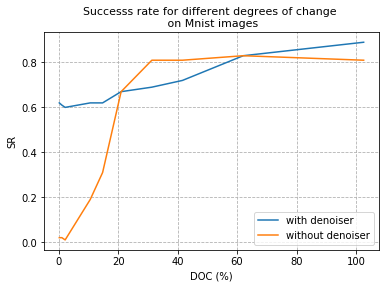

In [16]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with denoiser')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without denoiser')
# plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')

In [17]:
(SR_FGSM_dic_without_defense,SR_FGSM_dic_with_defense)=total_run('Cifar')

====data set selection====
====benign model training====
====adversarial data set creation====
====Denoiser training====
Epoch 1/30
164/164 [==============================] - 2s 10ms/step - loss: 1825.7601 - mean_squared_error: 1825.7601
Epoch 2/30
164/164 [==============================] - 2s 10ms/step - loss: 615.6863 - mean_squared_error: 615.6863
Epoch 3/30
164/164 [==============================] - 2s 10ms/step - loss: 418.5435 - mean_squared_error: 418.5435
Epoch 4/30
164/164 [==============================] - 2s 10ms/step - loss: 373.5916 - mean_squared_error: 373.5916
Epoch 5/30
164/164 [==============================] - 2s 10ms/step - loss: 299.8263 - mean_squared_error: 299.8263
Epoch 6/30
164/164 [==============================] - 2s 10ms/step - loss: 289.8519 - mean_squared_error: 289.8519
Epoch 7/30
164/164 [==============================] - 2s 10ms/step - loss: 223.7038 - mean_squared_error: 223.7038
Epoch 8/30
164/164 [==============================] - 2s 10ms/step - los

  0%|          | 0/100 [00:00<?, ?it/s]

====Adversarial attacks on model+denoiser====
======epislon: 0.1======


W0204 13:15:46.934872 140443992434496 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_3:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
W0204 13:15:46.936602 140443992434496 functional.py:587] Model was constructed with shape (None, 32, 32, 3) for input Tensor("input_2:0", shape=(None, 32, 32, 3), dtype=float32), but it was called on an input with incompatible shape (None, 1, 32, 32, 3).
  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 7======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 15======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 20======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 30======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


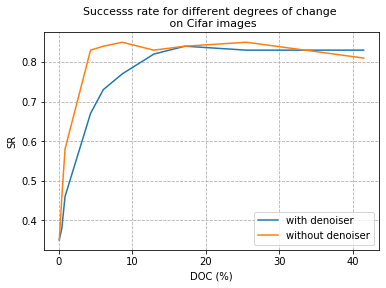

In [18]:
plt.plot(list(SR_FGSM_dic_with_defense.keys()),list(SR_FGSM_dic_with_defense.values()),label='with denoiser')
plt.plot(list(SR_FGSM_dic_without_defense.keys()),list(SR_FGSM_dic_without_defense.values()),label='without denoiser')
# plt.xscale('log')
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Cifar images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')

### Test of the denoiser againt a black box attack (boundary attack)

In [19]:
def prep_models(data_set_name):
    (X_train,X_test,y_train,y_test)=pick_data_set(data_set_name)
    model_effnet=train_and_save_effnet(data_set_name)
    (adv_list,benign_list,adv_true_label)=make_adv_data_set(data_set_name,model_effnet)
    autoencoder = Denoise()
    autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['MeanSquaredError'])
    autoencoder.fit(np.array(adv_list[:len(adv_list)-1000]),np.array(benign_list[:len(adv_list)-1000]),
                epochs=30,
                batch_size=32,
                shuffle=True)
    
    autoencoder.trainable=False
    inputs=Input(shape=(32,32,3))
    x=autoencoder(inputs)
    o=model_effnet(x)

    model_with_defense=Model(inputs,[o])

    model_with_defense.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    return(model_effnet,model_with_defense)

In [20]:
(model_without_def,model_with_def)=prep_models('Mnist')
(X_train,X_test,y_train,y_test)=pick_data_set('Mnist')
(adv_list,benign_list,adv_true_label)=make_adv_data_set('Mnist',model_without_def)

Epoch 1/30
27/27 [==============================] - 0s 9ms/step - loss: 3224.0967 - mean_squared_error: 3224.0967
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 1480.3414 - mean_squared_error: 1480.3414
Epoch 3/30
27/27 [==============================] - 0s 9ms/step - loss: 778.3447 - mean_squared_error: 778.3447
Epoch 4/30
27/27 [==============================] - 0s 9ms/step - loss: 506.2914 - mean_squared_error: 506.2914
Epoch 5/30
27/27 [==============================] - 0s 9ms/step - loss: 374.9768 - mean_squared_error: 374.9768
Epoch 6/30
27/27 [==============================] - 0s 10ms/step - loss: 299.4931 - mean_squared_error: 299.4931
Epoch 7/30
27/27 [==============================] - 0s 9ms/step - loss: 244.4944 - mean_squared_error: 244.4944
Epoch 8/30
27/27 [==============================] - 0s 9ms/step - loss: 215.8707 - mean_squared_error: 215.8707
Epoch 9/30
27/27 [==============================] - 0s 9ms/step - loss: 189.1802 - mean_squared_err

In [21]:
model_with_def.layers[0]

In [22]:
adv_true_label[0]

8

W0204 13:25:31.482059 140443992434496 base_layer.py:2377] Layer denoise is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0204 13:25:34.781690 140443992434496 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0204 13:25:34.922126 140443992434496 image.py:700] Clipping input data to the valid rang

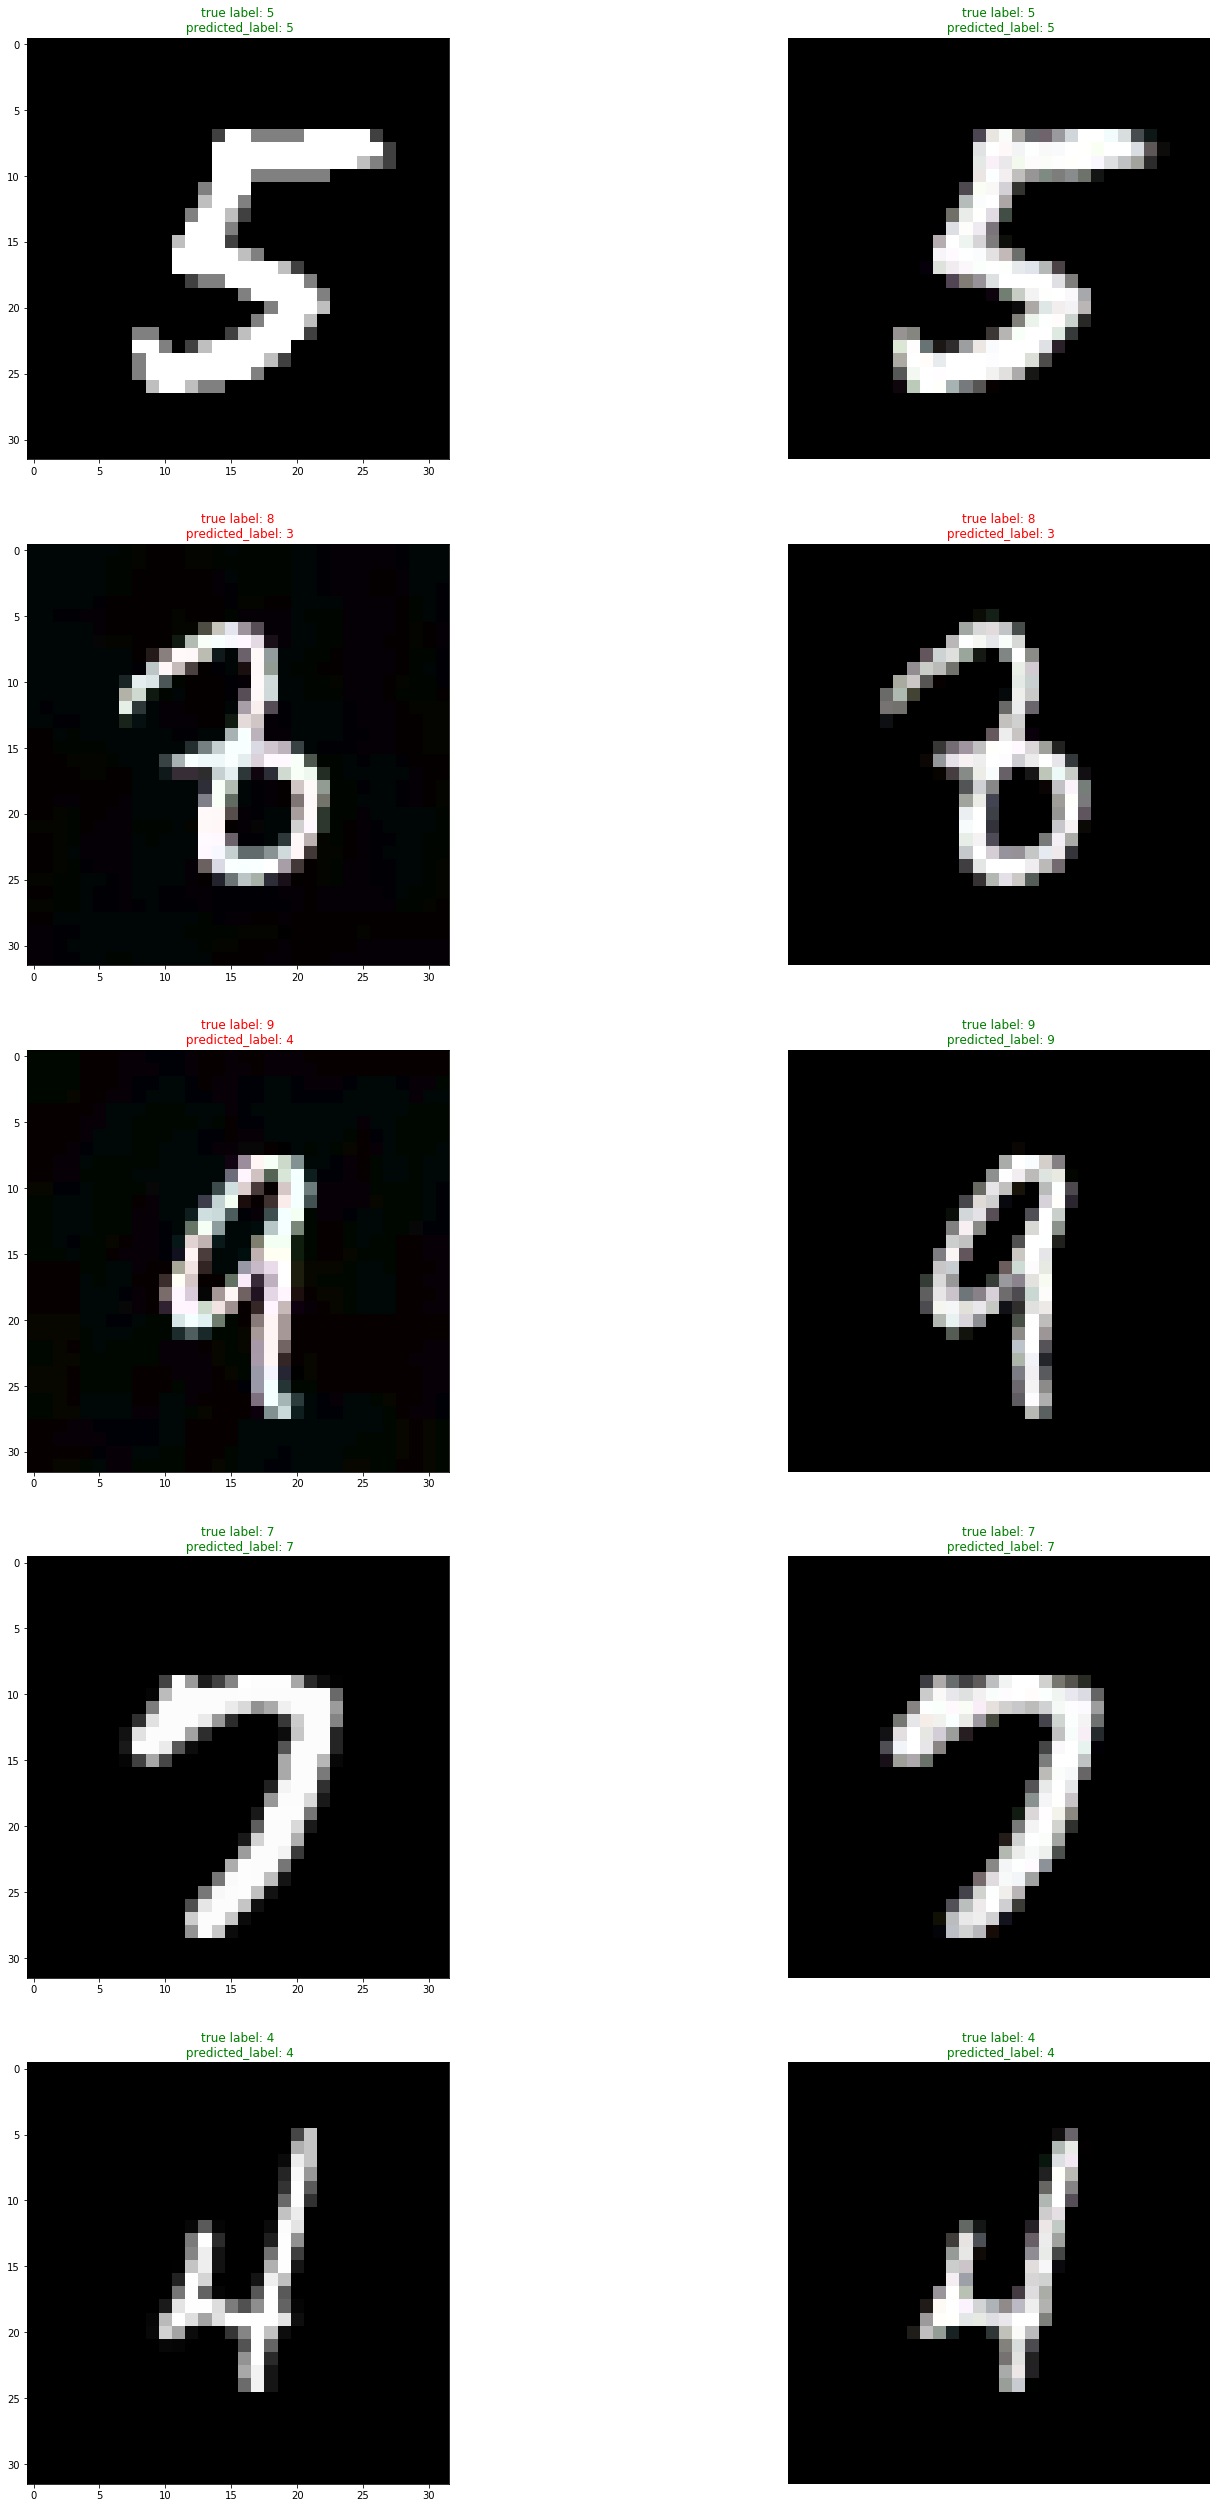

In [23]:
plt.figure(figsize=(25,45))
for i,(adv_image, true_label) in enumerate(zip(adv_list[len(adv_list)-1000:len(adv_list)-1000+5],adv_true_label[len(adv_list)-1000:len(adv_list)-1000+5])): 
   
    i=2*i
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(adv_image.astype('int32'))
    predicted_adv_label=np.argmax(model_without_def.predict(np.expand_dims(adv_image,axis=0)))
   
    if true_label==predicted_adv_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_adv_label),color=color)
    
    ax = plt.subplot(5, 2, i + 2)
    new_image=model_with_def.layers[1](np.expand_dims(adv_image,axis=0))
    predicted_label=np.argmax(model_with_def.predict(new_image))
    plt.imshow(np.squeeze(new_image).astype('int32'))
    if true_label==predicted_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label),color=color)
    plt.axis("off")
plt.show()



Adversarial image at step 0. L2 error 8060.161108163449 and class label 8.


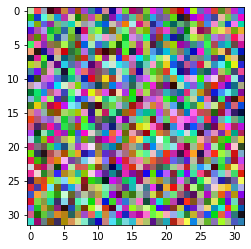



Adversarial image at step 1. L2 error 7979.559497965044 and class label 8.


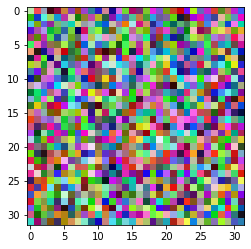



Adversarial image at step 2. L2 error 7859.925928577029 and class label 8.


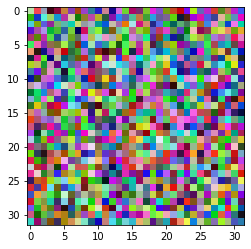



Adversarial image at step 3. L2 error 7683.254308938325 and class label 8.


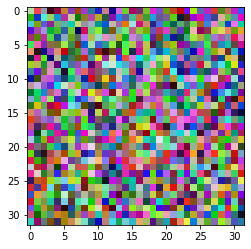



Adversarial image at step 4. L2 error 7424.333009124052 and class label 8.


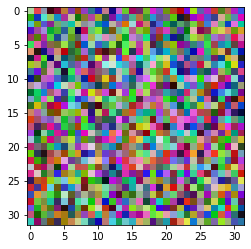



Adversarial image at step 5. L2 error 7049.226902560891 and class label 8.


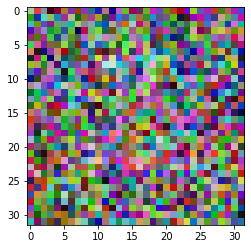



Adversarial image at step 6. L2 error 6943.541124308343 and class label 8.


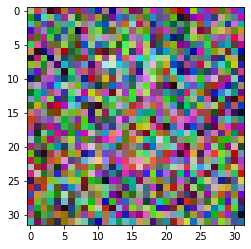



Adversarial image at step 7. L2 error 6874.104368102156 and class label 8.


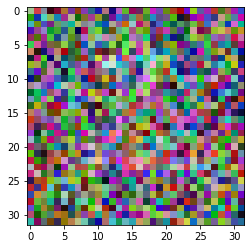



Adversarial image at step 8. L2 error 6828.249793617708 and class label 8.


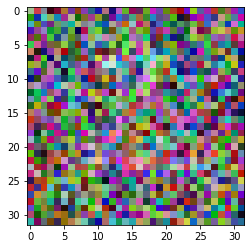



Adversarial image at step 9. L2 error 6759.95540024918 and class label 8.


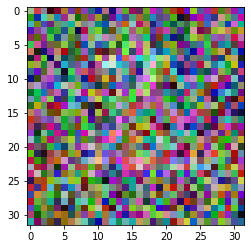



Adversarial image at step 10. L2 error 6658.596208089843 and class label 8.


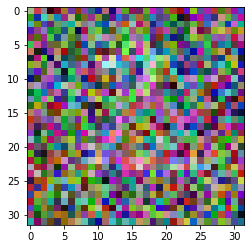



Adversarial image at step 11. L2 error 6508.877575841196 and class label 8.


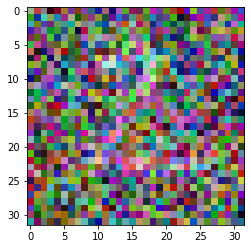



Adversarial image at step 12. L2 error 6362.457725507698 and class label 8.


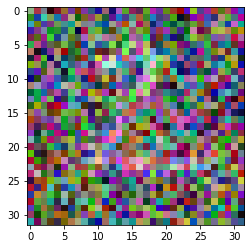



Adversarial image at step 13. L2 error 6147.905084457285 and class label 8.


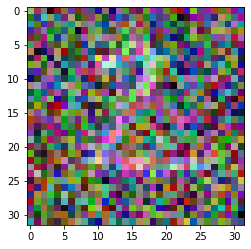



Adversarial image at step 14. L2 error 5940.237422989128 and class label 8.


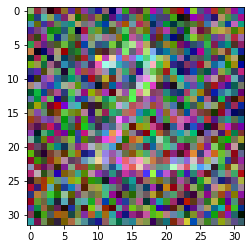



Adversarial image at step 15. L2 error 5738.917645520862 and class label 8.


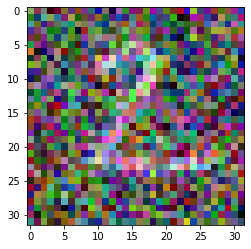



Adversarial image at step 16. L2 error 5544.089461274988 and class label 8.


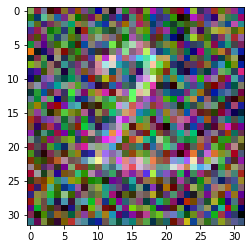



Adversarial image at step 17. L2 error 5259.150029729839 and class label 8.


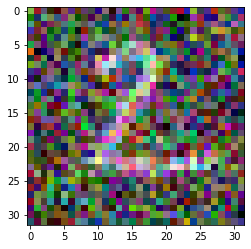



Adversarial image at step 18. L2 error 4980.128501834381 and class label 8.


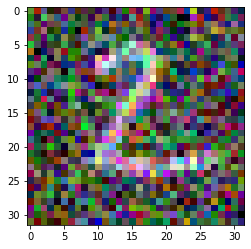



Adversarial image at step 19. L2 error 4712.990518022642 and class label 8.


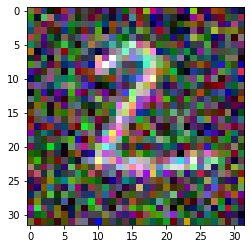



Adversarial image at step 20. L2 error 4436.57938691401 and class label 8.


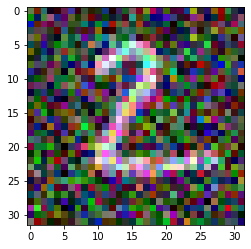



Adversarial image at step 21. L2 error 4057.5378917666967 and class label 8.


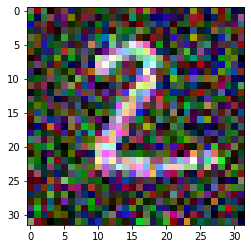



Adversarial image at step 22. L2 error 3709.2674005733475 and class label 8.


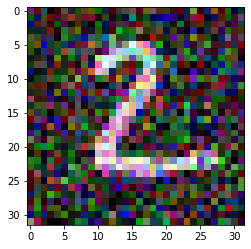



Adversarial image at step 23. L2 error 3388.731250684431 and class label 8.


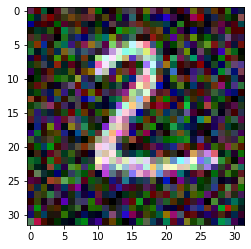



Adversarial image at step 24. L2 error 2971.398312345979 and class label 8.


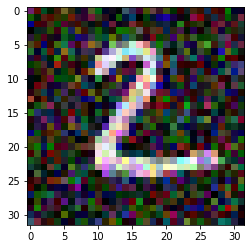



Adversarial image at step 25. L2 error 2437.81742295562 and class label 8.


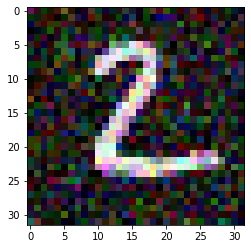



Adversarial image at step 26. L2 error 1795.7687645209967 and class label 8.


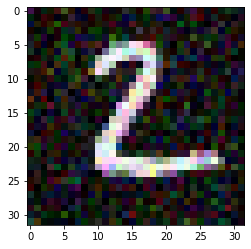



Adversarial image at step 27. L2 error 1572.6251254226624 and class label 8.


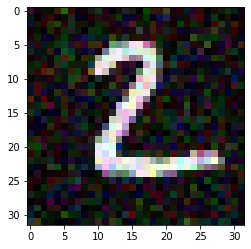



Adversarial image at step 28. L2 error 1476.4347226728428 and class label 8.


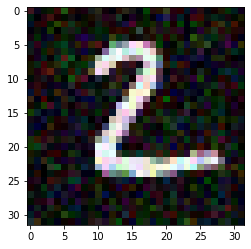



Adversarial image at step 29. L2 error 1410.1043801708809 and class label 8.


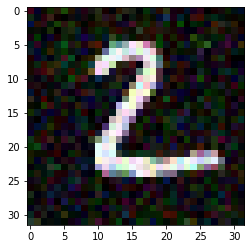



Adversarial image at step 30. L2 error 1355.4940453369727 and class label 8.


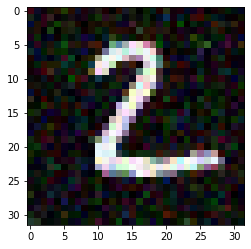



Adversarial image at step 31. L2 error 1304.2279222629243 and class label 8.


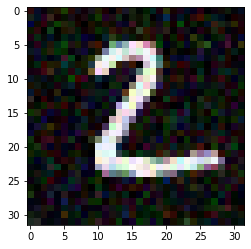



Adversarial image at step 32. L2 error 1268.351539258474 and class label 8.


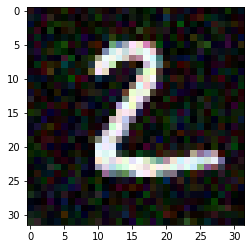



Adversarial image at step 33. L2 error 1233.830372638096 and class label 8.


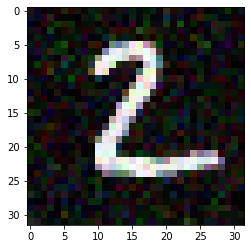



Adversarial image at step 34. L2 error 1216.7612689473342 and class label 8.


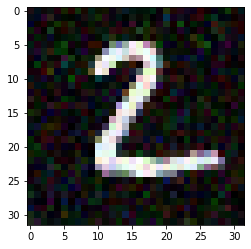



Adversarial image at step 35. L2 error 1196.235888776363 and class label 8.


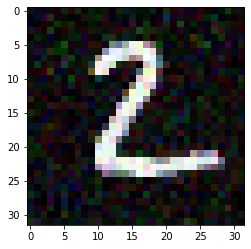



Adversarial image at step 36. L2 error 1168.51207041225 and class label 8.


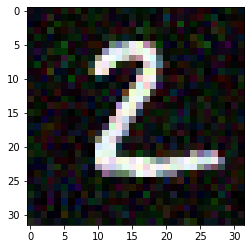



Adversarial image at step 37. L2 error 1128.3656627018581 and class label 8.


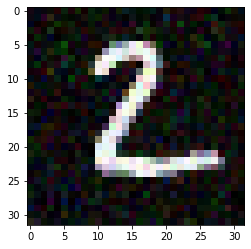



Adversarial image at step 38. L2 error 1102.474378703354 and class label 8.


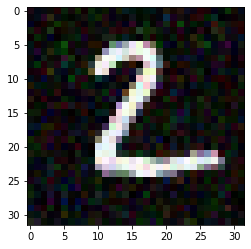



Adversarial image at step 39. L2 error 1077.1135863999725 and class label 8.


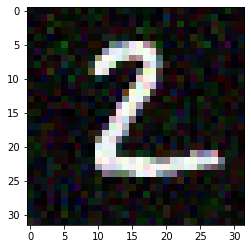



Adversarial image at step 40. L2 error 1052.3563245286748 and class label 8.


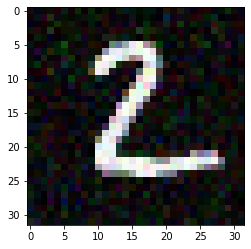



Adversarial image at step 41. L2 error 1028.11808780709 and class label 8.


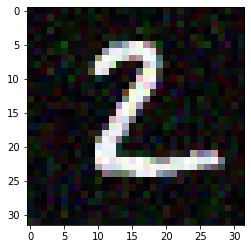



Adversarial image at step 42. L2 error 1004.3007164089481 and class label 8.


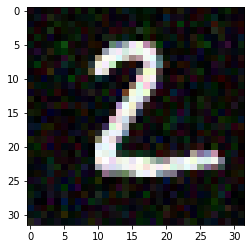



Adversarial image at step 43. L2 error 981.4756988965986 and class label 8.


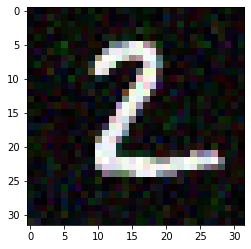



Adversarial image at step 44. L2 error 959.1536800146748 and class label 8.


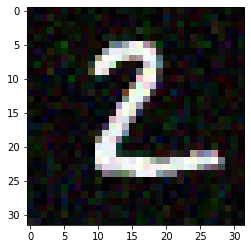



Adversarial image at step 45. L2 error 944.6329345024365 and class label 8.


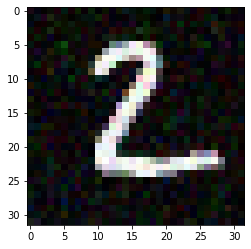



Adversarial image at step 46. L2 error 935.0495952687833 and class label 8.


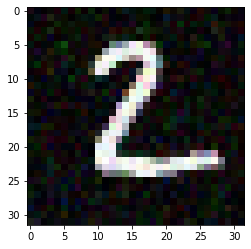



Adversarial image at step 47. L2 error 925.552869716172 and class label 8.


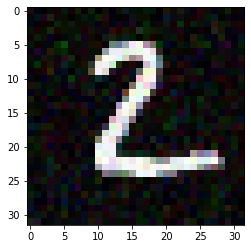



Adversarial image at step 48. L2 error 916.1222630790862 and class label 8.


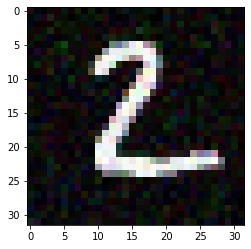



Adversarial image at step 49. L2 error 906.8893352730764 and class label 8.


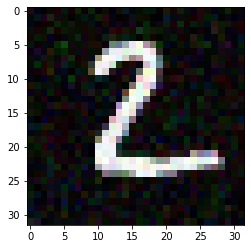



Adversarial image at step 50. L2 error 900.7845463273492 and class label 8.


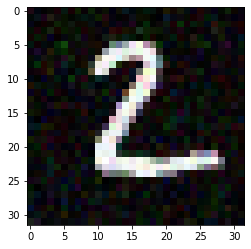



Adversarial image at step 51. L2 error 894.7340299773667 and class label 8.


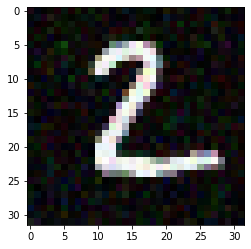



Adversarial image at step 52. L2 error 888.7059537685028 and class label 8.


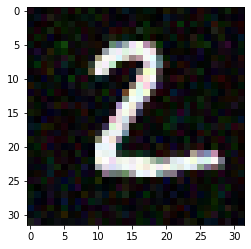



Adversarial image at step 53. L2 error 879.7659951813903 and class label 8.


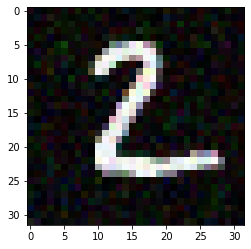



Adversarial image at step 54. L2 error 873.8521094833847 and class label 8.


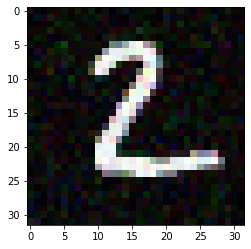



Adversarial image at step 55. L2 error 865.0500584361918 and class label 8.


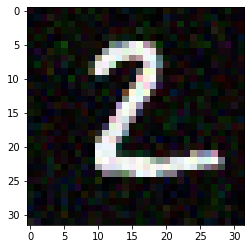



Adversarial image at step 56. L2 error 851.9664205366303 and class label 8.


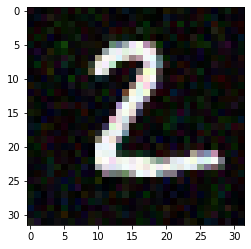



Adversarial image at step 57. L2 error 849.0826574827137 and class label 8.


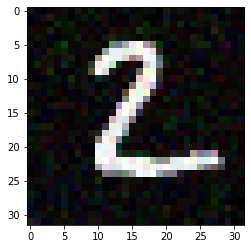



Adversarial image at step 58. L2 error 845.1087203167697 and class label 8.


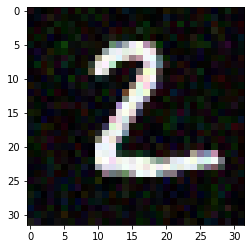



Adversarial image at step 59. L2 error 839.375924871064 and class label 8.


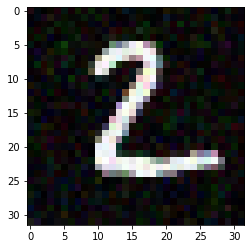



Adversarial image at step 60. L2 error 830.890308922347 and class label 8.


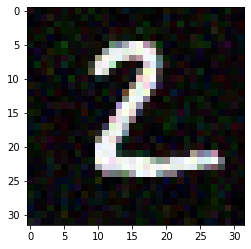



Adversarial image at step 61. L2 error 822.5230740613589 and class label 8.


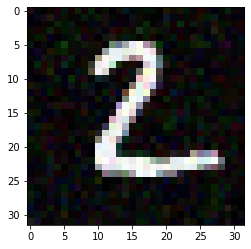



Adversarial image at step 62. L2 error 810.1757371609009 and class label 8.


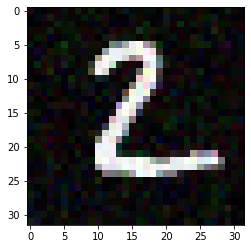



Adversarial image at step 63. L2 error 802.0164792935841 and class label 8.


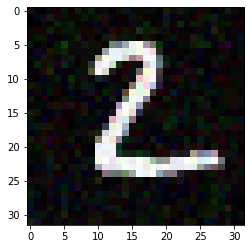



Adversarial image at step 64. L2 error 793.9615916262723 and class label 8.


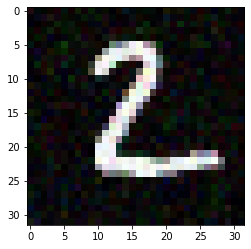



Adversarial image at step 65. L2 error 791.5904119364035 and class label 8.


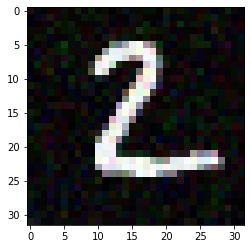



Adversarial image at step 66. L2 error 788.0608010247965 and class label 8.


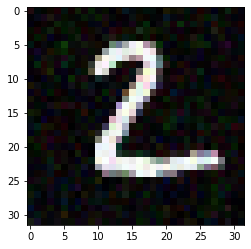



Adversarial image at step 67. L2 error 782.7977524115176 and class label 8.


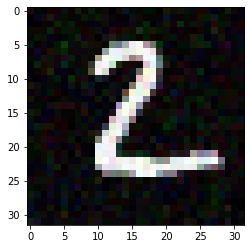



Adversarial image at step 68. L2 error 777.572492624709 and class label 8.


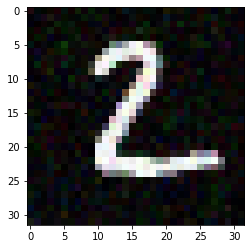



Adversarial image at step 69. L2 error 772.3732457736368 and class label 8.


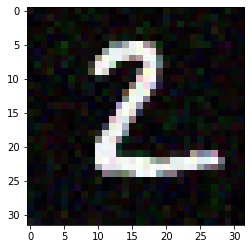



Adversarial image at step 70. L2 error 767.1834022129793 and class label 8.


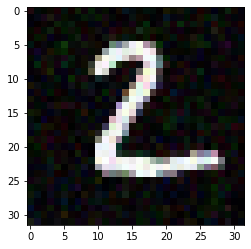



Adversarial image at step 71. L2 error 759.4820228985357 and class label 8.


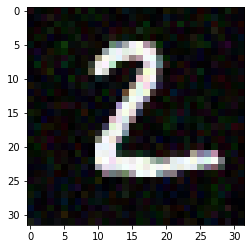



Adversarial image at step 72. L2 error 754.3814517305758 and class label 8.


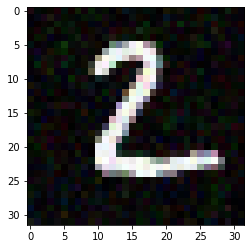



Adversarial image at step 73. L2 error 746.728371545928 and class label 8.


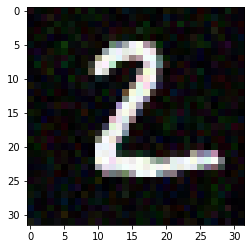



Adversarial image at step 74. L2 error 739.2179989817528 and class label 8.


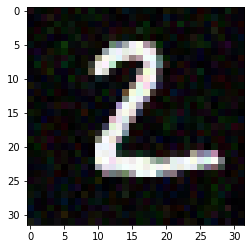



Adversarial image at step 75. L2 error 731.7797128466843 and class label 8.


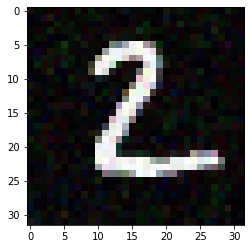



Adversarial image at step 76. L2 error 724.4255344912503 and class label 8.


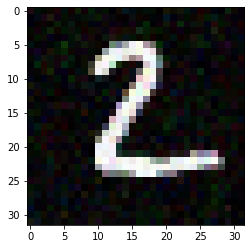



Adversarial image at step 77. L2 error 723.4248308363416 and class label 8.


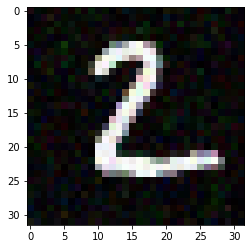



Adversarial image at step 78. L2 error 721.978108500464 and class label 8.


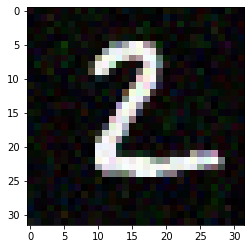



Adversarial image at step 79. L2 error 719.8217659264458 and class label 8.


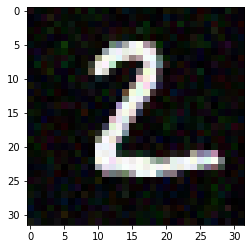



Adversarial image at step 80. L2 error 716.5894676619629 and class label 8.


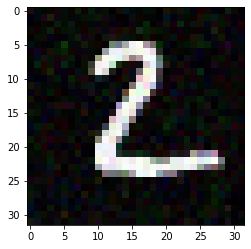



Adversarial image at step 81. L2 error 711.7939715110814 and class label 8.


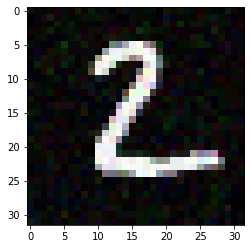



Adversarial image at step 82. L2 error 707.0089983430187 and class label 8.


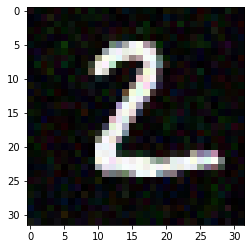



Adversarial image at step 83. L2 error 702.2131919726868 and class label 8.


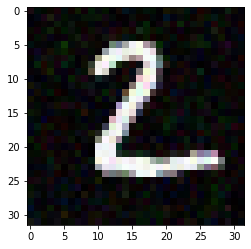



Adversarial image at step 84. L2 error 697.4906896991513 and class label 8.


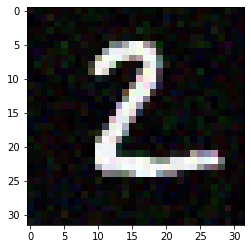



Adversarial image at step 85. L2 error 690.4785378803446 and class label 8.


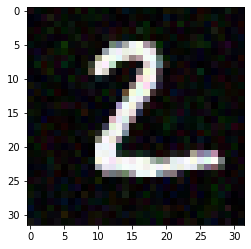



Adversarial image at step 86. L2 error 687.36961326734 and class label 8.


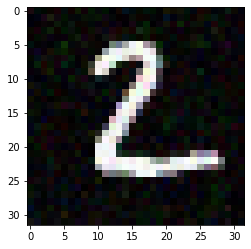



Adversarial image at step 87. L2 error 685.2905903942368 and class label 8.


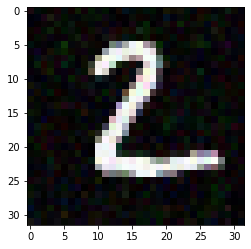



Adversarial image at step 88. L2 error 683.216551121243 and class label 8.


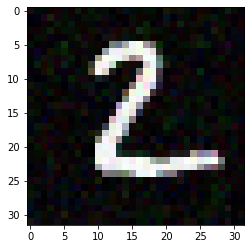



Adversarial image at step 89. L2 error 680.1429752939739 and class label 8.


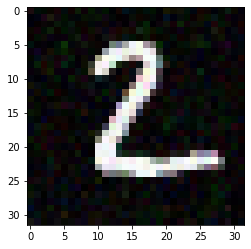



Adversarial image at step 90. L2 error 675.5677862783078 and class label 8.


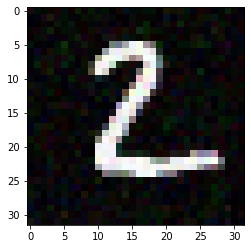



Adversarial image at step 91. L2 error 671.0480616497313 and class label 8.


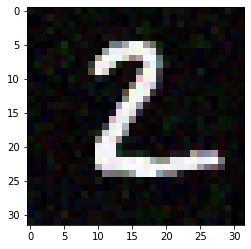



Adversarial image at step 92. L2 error 669.7072125529056 and class label 8.


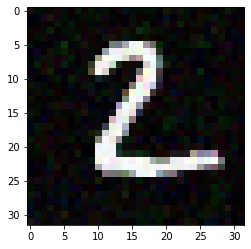



Adversarial image at step 93. L2 error 667.7120435177435 and class label 8.


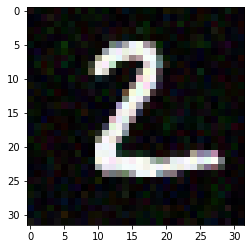



Adversarial image at step 94. L2 error 666.3838621612604 and class label 8.


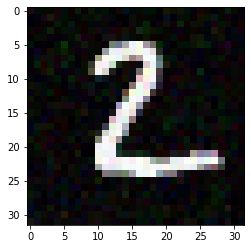



Adversarial image at step 95. L2 error 664.401966681284 and class label 8.


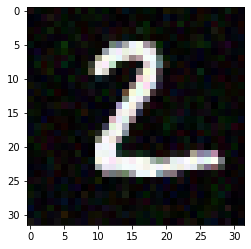



Adversarial image at step 96. L2 error 662.4261843321732 and class label 8.


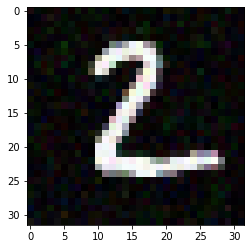



Adversarial image at step 97. L2 error 659.4731513642677 and class label 8.


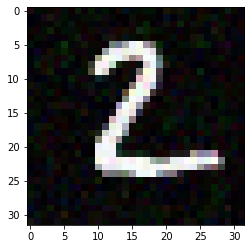



Adversarial image at step 98. L2 error 655.0682111574314 and class label 8.


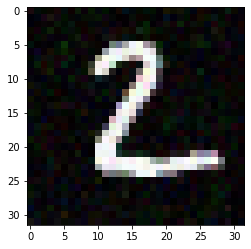



Adversarial image at step 99. L2 error 650.6863835695484 and class label 8.


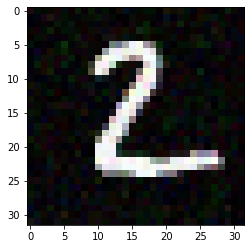

In [24]:
classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_without_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
target=X_test[1]
image_list=[]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_without_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break



Adversarial image at step 0. L2 error 8006.421658367018 and class label 8.


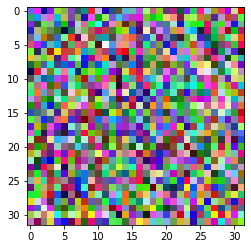



Adversarial image at step 1. L2 error 7926.3574628232855 and class label 8.


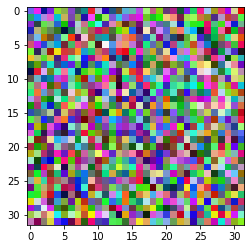



Adversarial image at step 2. L2 error 7807.521530274959 and class label 8.


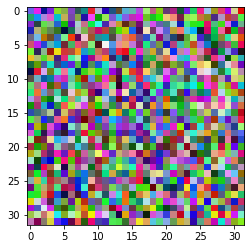



Adversarial image at step 3. L2 error 7632.027801931841 and class label 8.


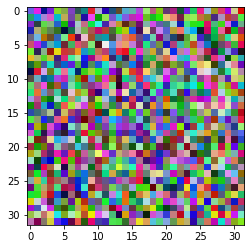



Adversarial image at step 4. L2 error 7374.832740495689 and class label 8.


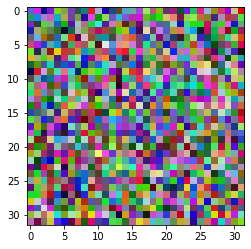



Adversarial image at step 5. L2 error 7002.227184276118 and class label 8.


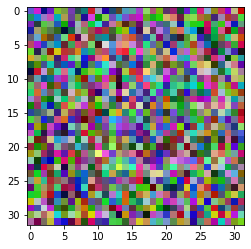



Adversarial image at step 6. L2 error 6471.8226544347 and class label 8.


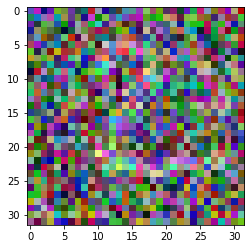



Adversarial image at step 7. L2 error 5736.84873535192 and class label 8.


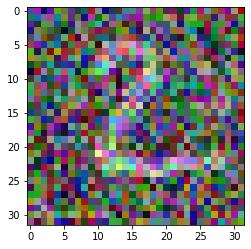



Adversarial image at step 8. L2 error 5543.516829598433 and class label 8.


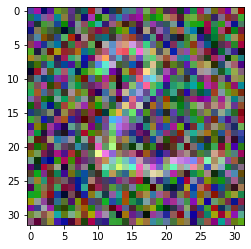



Adversarial image at step 9. L2 error 5488.057595086603 and class label 8.


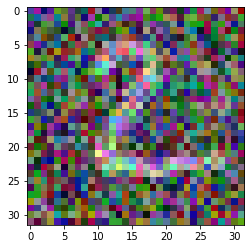



Adversarial image at step 10. L2 error 5451.428629277625 and class label 8.


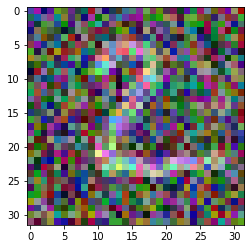



Adversarial image at step 11. L2 error 5396.861265953779 and class label 8.


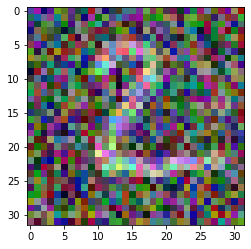



Adversarial image at step 12. L2 error 5315.806935614847 and class label 8.


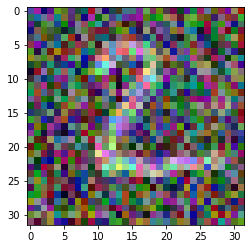



Adversarial image at step 13. L2 error 5195.903153268139 and class label 8.


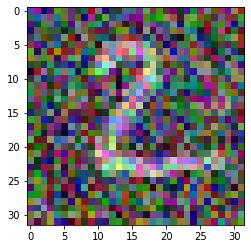



Adversarial image at step 14. L2 error 5078.843867943615 and class label 8.


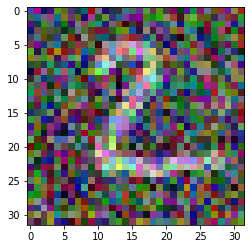



Adversarial image at step 15. L2 error 4964.244652248321 and class label 8.


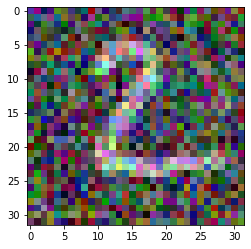



Adversarial image at step 16. L2 error 4852.233172614799 and class label 8.


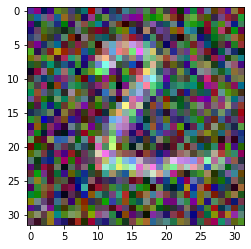



Adversarial image at step 17. L2 error 4742.355495233395 and class label 8.


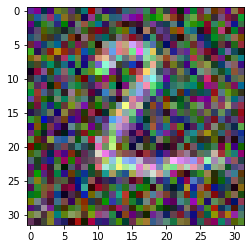



Adversarial image at step 18. L2 error 4635.263168666409 and class label 8.


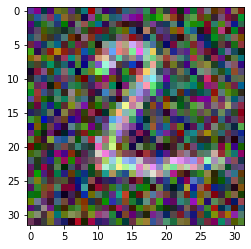



Adversarial image at step 19. L2 error 4565.380187469911 and class label 8.


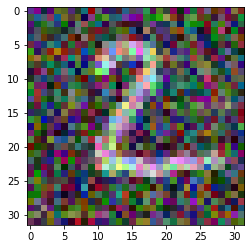



Adversarial image at step 20. L2 error 4496.573460198208 and class label 8.


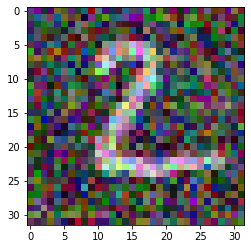



Adversarial image at step 21. L2 error 4450.498575058189 and class label 8.


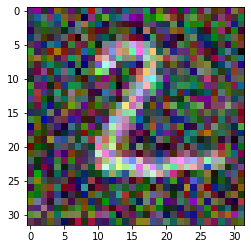



Adversarial image at step 22. L2 error 4404.607870493922 and class label 8.


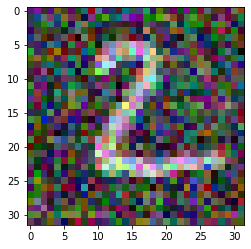



Adversarial image at step 23. L2 error 4334.999071274186 and class label 8.


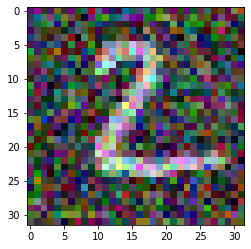



Adversarial image at step 24. L2 error 4228.219719899291 and class label 8.


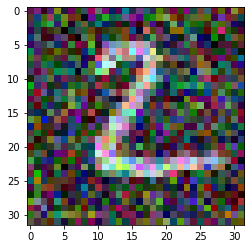



Adversarial image at step 25. L2 error 4119.7822389902785 and class label 8.


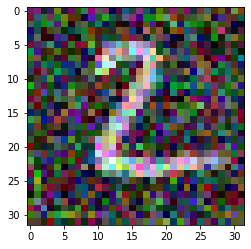



Adversarial image at step 26. L2 error 3966.338535523835 and class label 8.


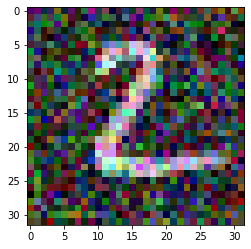



Adversarial image at step 27. L2 error 3911.2070213911265 and class label 8.


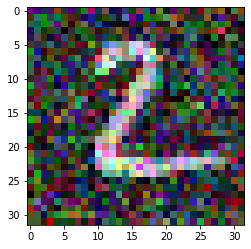



Adversarial image at step 28. L2 error 3865.9730838147984 and class label 8.


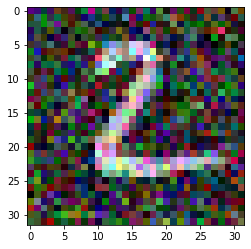



Adversarial image at step 29. L2 error 3825.09009463975 and class label 8.


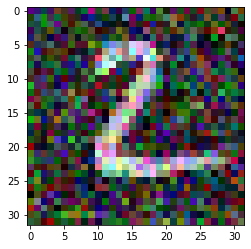



Adversarial image at step 30. L2 error 3782.01538819768 and class label 8.


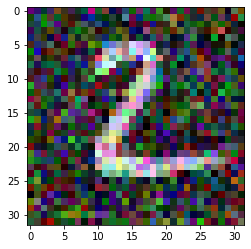



Adversarial image at step 31. L2 error 3759.371436246562 and class label 8.


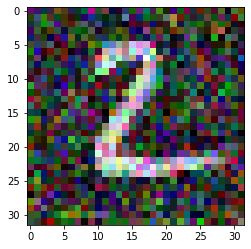



Adversarial image at step 32. L2 error 3727.9856785808392 and class label 8.


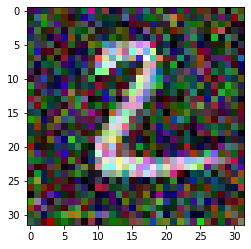



Adversarial image at step 33. L2 error 3696.96460523289 and class label 8.


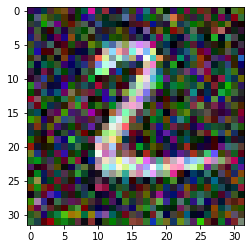



Adversarial image at step 34. L2 error 3657.018891529654 and class label 8.


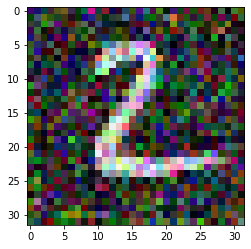



Adversarial image at step 35. L2 error 3614.8469025739273 and class label 8.


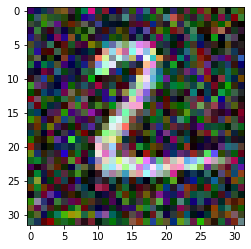



Adversarial image at step 36. L2 error 3576.254588516041 and class label 8.


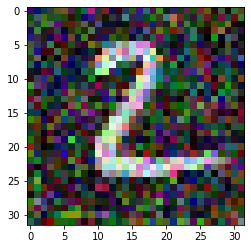



Adversarial image at step 37. L2 error 3538.5252006128608 and class label 8.


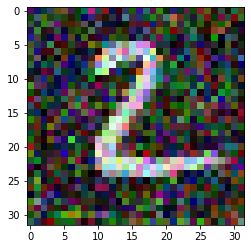



Adversarial image at step 38. L2 error 3500.614695702131 and class label 8.


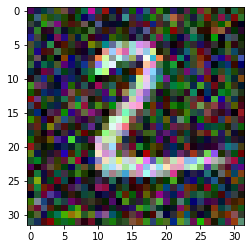



Adversarial image at step 39. L2 error 3463.29283459749 and class label 8.


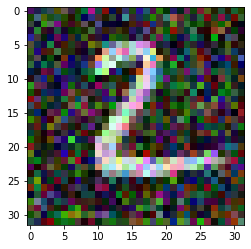



Adversarial image at step 40. L2 error 3451.1964814687663 and class label 8.


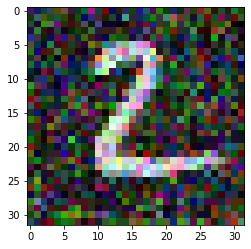



Adversarial image at step 41. L2 error 3439.9454640899503 and class label 8.


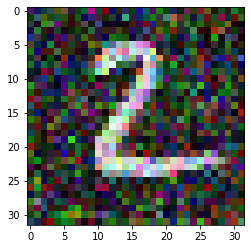



Adversarial image at step 42. L2 error 3423.97547952122 and class label 8.


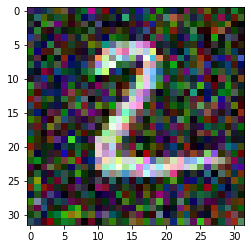



Adversarial image at step 43. L2 error 3413.2229785056434 and class label 8.


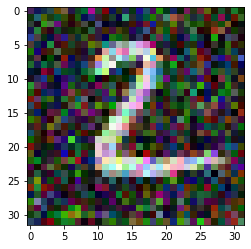



Adversarial image at step 44. L2 error 3396.2758667409526 and class label 8.


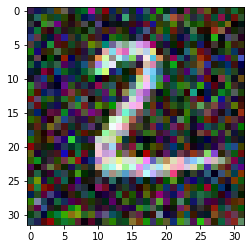



Adversarial image at step 45. L2 error 3372.1603198443036 and class label 8.


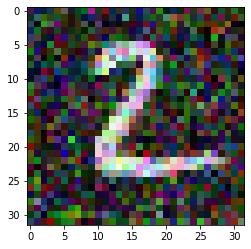



Adversarial image at step 46. L2 error 3356.343246202983 and class label 8.


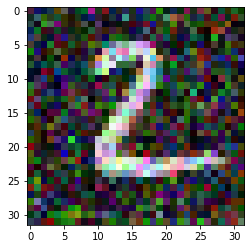



Adversarial image at step 47. L2 error 3340.8004149727203 and class label 8.


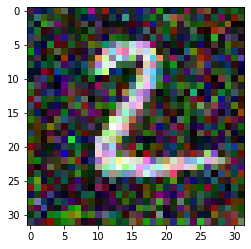



Adversarial image at step 48. L2 error 3325.186861787906 and class label 8.


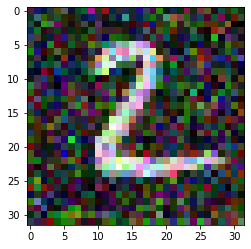



Adversarial image at step 49. L2 error 3302.729452947337 and class label 8.


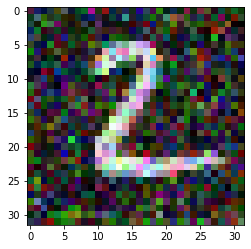



Adversarial image at step 50. L2 error 3292.356084269862 and class label 8.


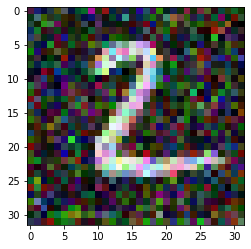



Adversarial image at step 51. L2 error 3282.4193738971344 and class label 8.


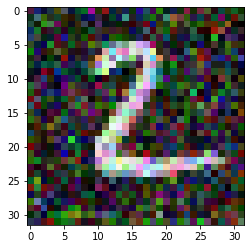



Adversarial image at step 52. L2 error 3267.6131241489147 and class label 8.


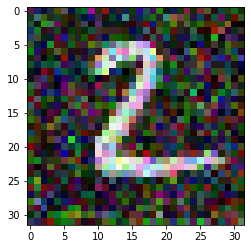



Adversarial image at step 53. L2 error 3252.8489670912877 and class label 8.


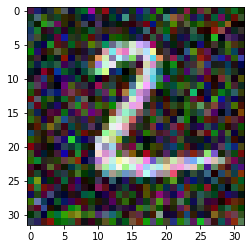



Adversarial image at step 54. L2 error 3238.147558156495 and class label 8.


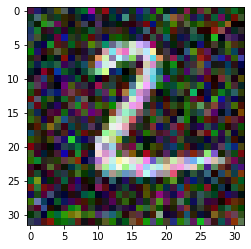



Adversarial image at step 55. L2 error 3223.5789995252558 and class label 8.


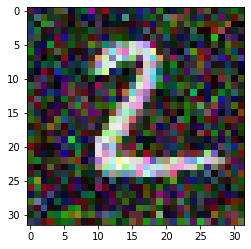



Adversarial image at step 56. L2 error 3208.908764360574 and class label 8.


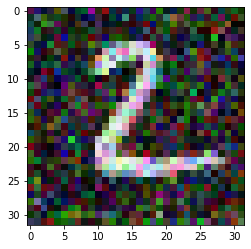



Adversarial image at step 57. L2 error 3187.176497480303 and class label 8.


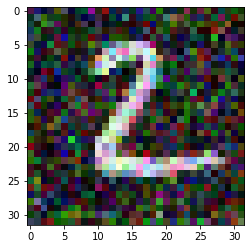



Adversarial image at step 58. L2 error 3177.2162711223905 and class label 8.


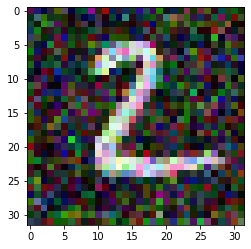



Adversarial image at step 59. L2 error 3167.563531835235 and class label 8.


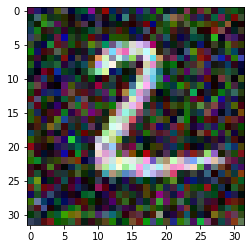



Adversarial image at step 60. L2 error 3158.0724742150383 and class label 8.


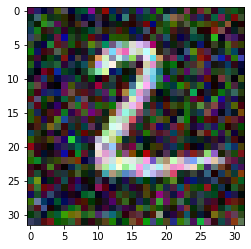



Adversarial image at step 61. L2 error 3148.5951196047145 and class label 8.


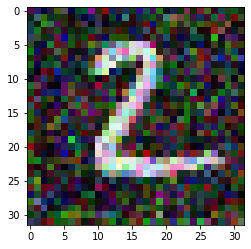



Adversarial image at step 62. L2 error 3134.3796628476807 and class label 8.


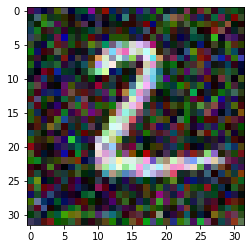



Adversarial image at step 63. L2 error 3119.770427427903 and class label 8.


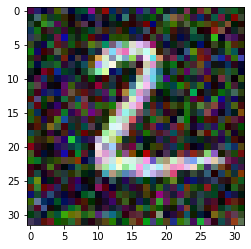



Adversarial image at step 64. L2 error 3105.389256544397 and class label 8.


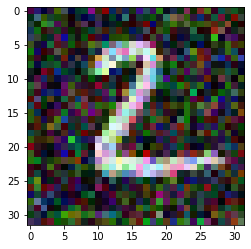



Adversarial image at step 65. L2 error 3090.3736180800074 and class label 8.


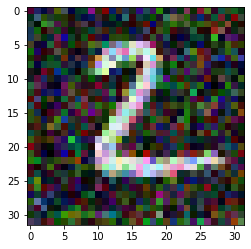



Adversarial image at step 66. L2 error 3068.5987018107558 and class label 8.


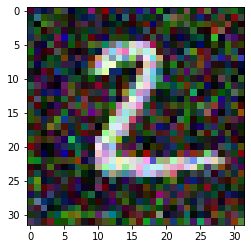



Adversarial image at step 67. L2 error 3047.459830883502 and class label 8.


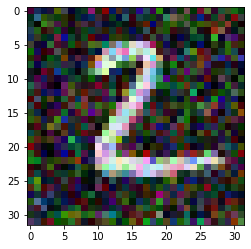



Adversarial image at step 68. L2 error 3037.2149302983726 and class label 8.


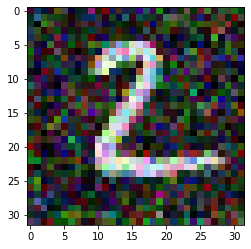



Adversarial image at step 69. L2 error 3023.033664150273 and class label 8.


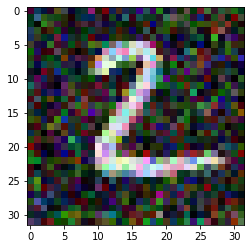



Adversarial image at step 70. L2 error 3009.419598149781 and class label 8.


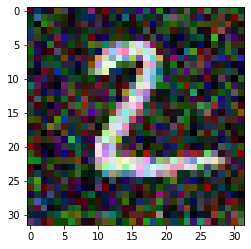



Adversarial image at step 71. L2 error 2989.210898621122 and class label 8.


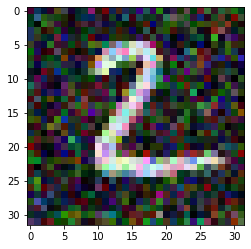



Adversarial image at step 72. L2 error 2975.7866936784926 and class label 8.


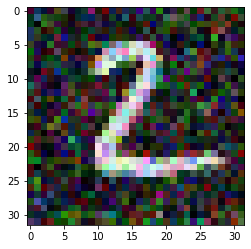



Adversarial image at step 73. L2 error 2962.4093911054415 and class label 8.


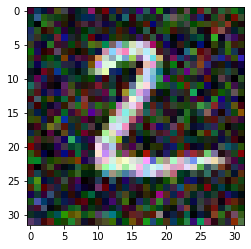



Adversarial image at step 74. L2 error 2949.107779867797 and class label 8.


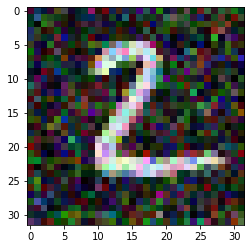



Adversarial image at step 75. L2 error 2940.222535624049 and class label 8.


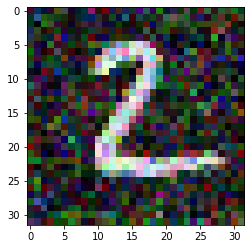



Adversarial image at step 76. L2 error 2931.179644505016 and class label 8.


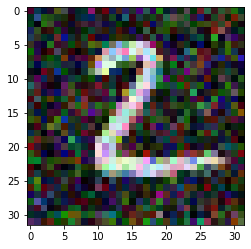



Adversarial image at step 77. L2 error 2917.548619956557 and class label 8.


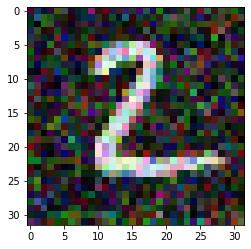



Adversarial image at step 78. L2 error 2911.320884141822 and class label 8.


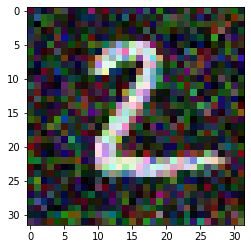



Adversarial image at step 79. L2 error 2902.4215581065037 and class label 8.


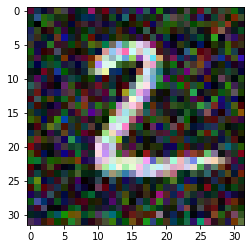



Adversarial image at step 80. L2 error 2893.6422421744514 and class label 8.


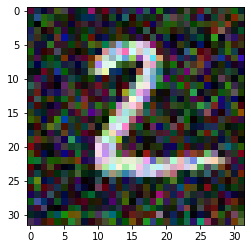



Adversarial image at step 81. L2 error 2884.8991402920756 and class label 8.


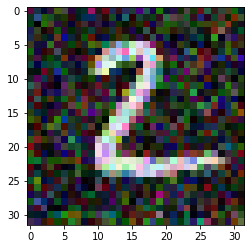



Adversarial image at step 82. L2 error 2878.791784400986 and class label 8.


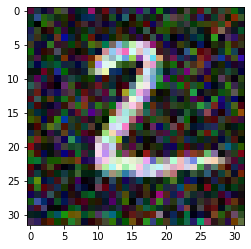



Adversarial image at step 83. L2 error 2872.9866344250463 and class label 8.


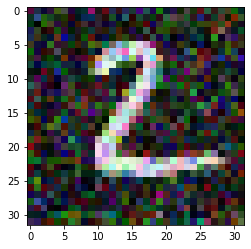



Adversarial image at step 84. L2 error 2864.420896853986 and class label 8.


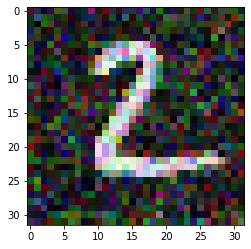



Adversarial image at step 85. L2 error 2858.676565791496 and class label 8.


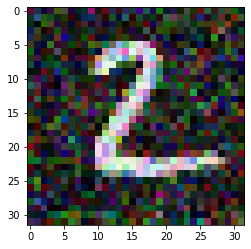



Adversarial image at step 86. L2 error 2852.981139040677 and class label 8.


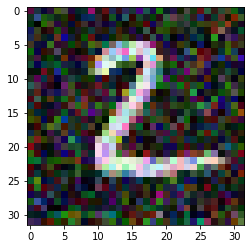



Adversarial image at step 87. L2 error 2849.1130761622103 and class label 8.


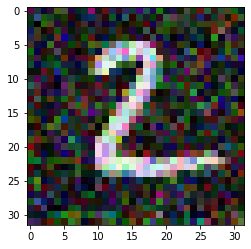



Adversarial image at step 88. L2 error 2843.3168375409277 and class label 8.


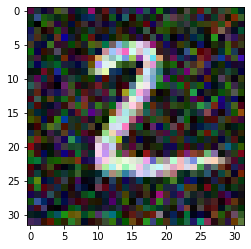



Adversarial image at step 89. L2 error 2837.6367355262964 and class label 8.


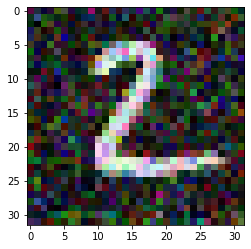



Adversarial image at step 90. L2 error 2831.7570873330114 and class label 8.


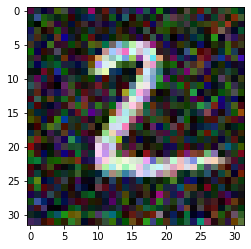



Adversarial image at step 91. L2 error 2826.0124046502096 and class label 8.


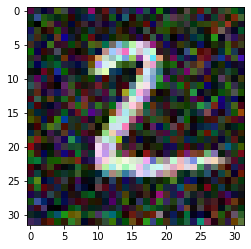



Adversarial image at step 92. L2 error 2817.453015843512 and class label 8.


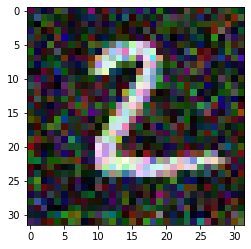



Adversarial image at step 93. L2 error 2804.4688801219017 and class label 8.


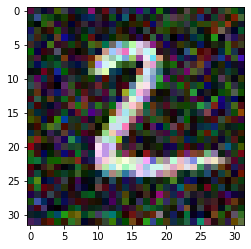



Adversarial image at step 94. L2 error 2791.3730133550466 and class label 8.


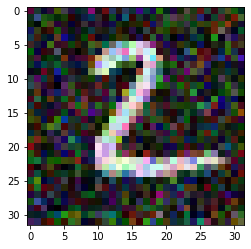



Adversarial image at step 95. L2 error 2787.224492113105 and class label 8.


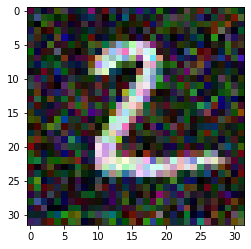



Adversarial image at step 96. L2 error 2784.5831289667267 and class label 8.


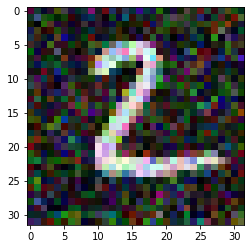



Adversarial image at step 97. L2 error 2782.0214306428584 and class label 8.


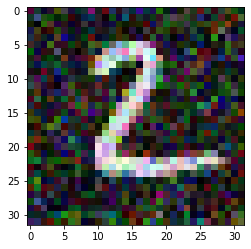



Adversarial image at step 98. L2 error 2778.2893169338704 and class label 8.


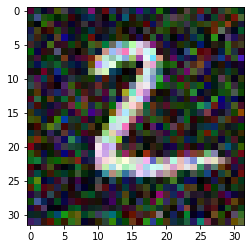



Adversarial image at step 99. L2 error 2772.657760730737 and class label 8.


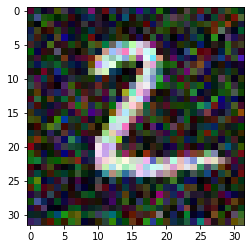

In [25]:
classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_with_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[1]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_with_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


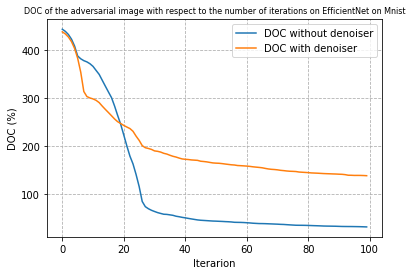

In [26]:
plt.plot(list(degree_of_change_without_def.keys()),list(degree_of_change_without_def.values()),label='DOC without denoiser')
plt.plot(list(degree_of_change_with_def.keys()),list(degree_of_change_with_def.values()),label='DOC with denoiser')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet on Mnist', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()

In [27]:
(model_without_def,model_with_def)=prep_models('Cifar')
(X_train,X_test,y_train,y_test)=pick_data_set('Cifar')
(adv_list,benign_list,adv_true_label)=make_adv_data_set('Cifar',model_without_def)

Epoch 1/30
164/164 [==============================] - 2s 10ms/step - loss: 2021.6351 - mean_squared_error: 2021.6351
Epoch 2/30
164/164 [==============================] - 2s 10ms/step - loss: 637.9960 - mean_squared_error: 637.9960
Epoch 3/30
164/164 [==============================] - 2s 9ms/step - loss: 445.1412 - mean_squared_error: 445.1412
Epoch 4/30
164/164 [==============================] - 2s 9ms/step - loss: 355.7420 - mean_squared_error: 355.7420
Epoch 5/30
164/164 [==============================] - 2s 10ms/step - loss: 326.9362 - mean_squared_error: 326.9362
Epoch 6/30
164/164 [==============================] - 2s 10ms/step - loss: 243.1601 - mean_squared_error: 243.1601
Epoch 7/30
164/164 [==============================] - 2s 10ms/step - loss: 223.3700 - mean_squared_error: 223.3700
Epoch 8/30
164/164 [==============================] - 2s 10ms/step - loss: 204.3565 - mean_squared_error: 204.3565
Epoch 9/30
164/164 [==============================] - 2s 9ms/step - loss: 204.23

In [28]:
dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

W0204 13:46:12.991008 140443992434496 base_layer.py:2377] Layer denoise is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because its dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0204 13:46:17.023361 140443992434496 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


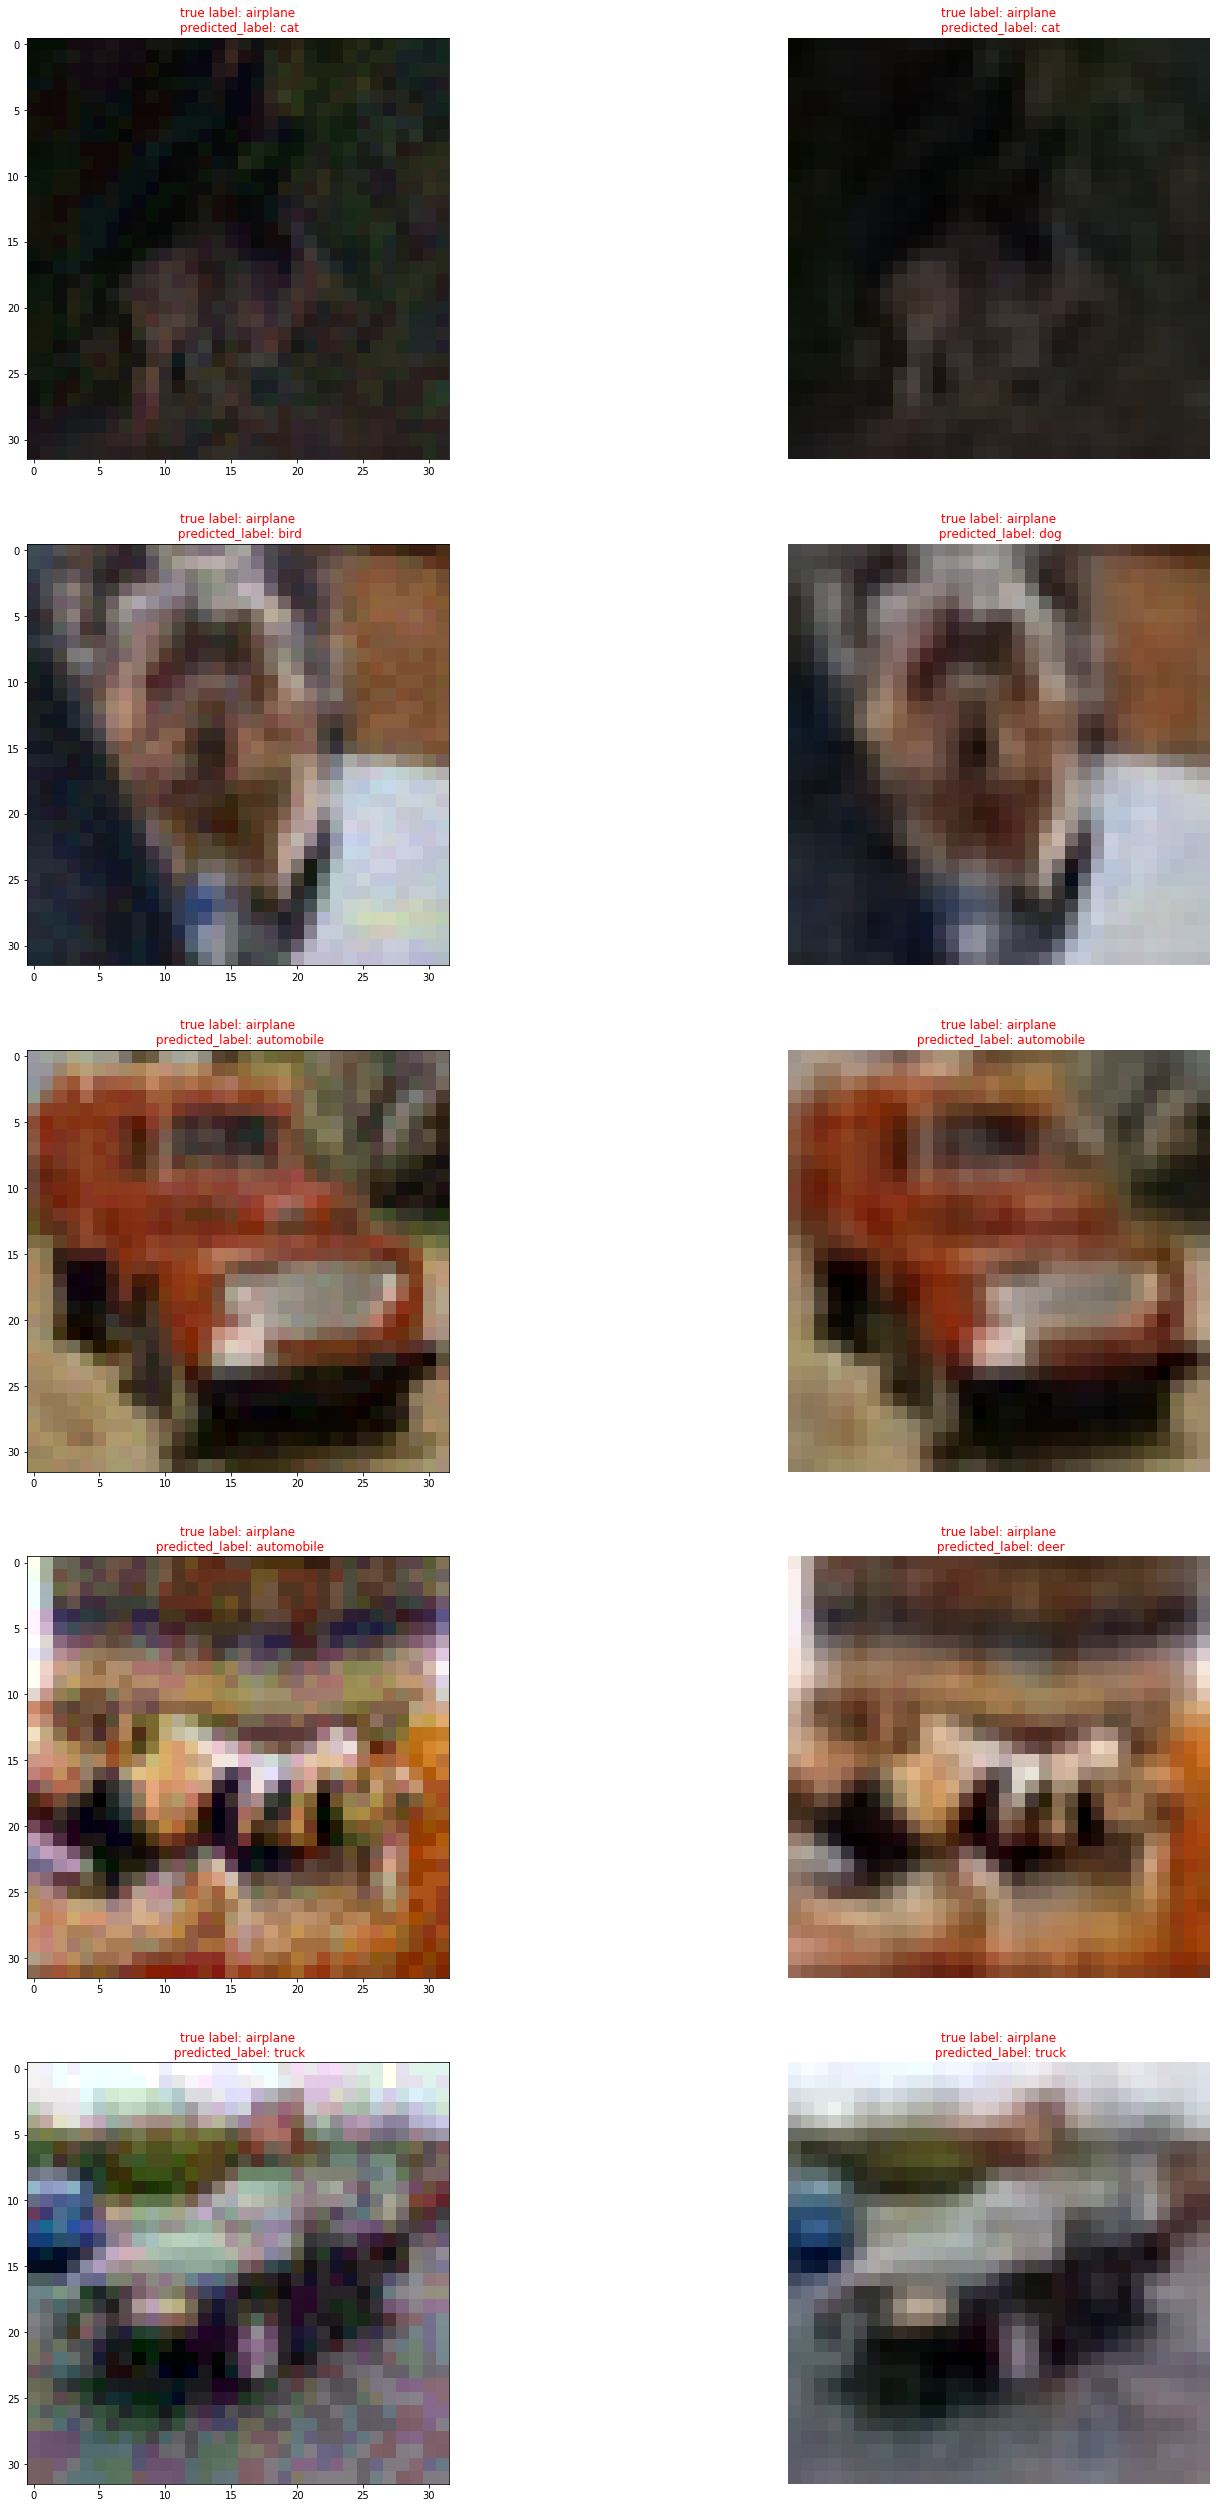

In [29]:
plt.figure(figsize=(25,45))
for i,(adv_image, true_label) in enumerate(zip(adv_list[len(adv_list)-1000:len(adv_list)-1000+5],adv_true_label[len(adv_list)-1000:len(adv_list)-1000+5])): 
    true_label=np.argmax(true_label)
    i=2*i
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(adv_image.astype('int32'))
    predicted_adv_label=dict_classes[np.argmax(model_without_def.predict(np.expand_dims(adv_image,axis=0)))]
    true_label=dict_classes[true_label]
    if true_label==predicted_adv_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_adv_label),color=color)
    
    ax = plt.subplot(5, 2, i + 2)
    new_image=model_with_def.layers[1](np.expand_dims(adv_image,axis=0))
    predicted_label=dict_classes[np.argmax(model_with_def.predict(new_image))]
    plt.imshow(np.squeeze(new_image).astype('int32'))
    if true_label==predicted_label:
        color='green'
    else:
        color='red'
    plt.title('true label: '+str(true_label)+'\n predicted_label: '+str(predicted_label),color=color)
    plt.axis("off")
plt.show()



Adversarial image at step 0. L2 error 6138.670313057682 and class label 6.


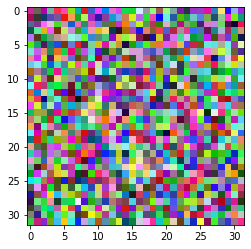



Adversarial image at step 1. L2 error 6077.283545909939 and class label 6.


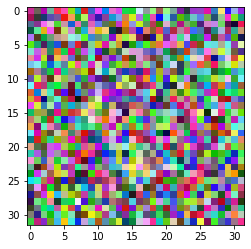



Adversarial image at step 2. L2 error 5986.169840503523 and class label 6.


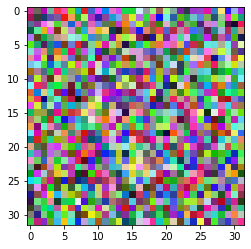



Adversarial image at step 3. L2 error 5851.615606775718 and class label 6.


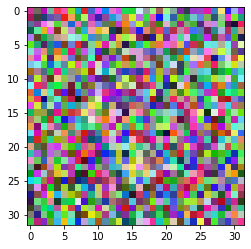



Adversarial image at step 4. L2 error 5654.419521378076 and class label 6.


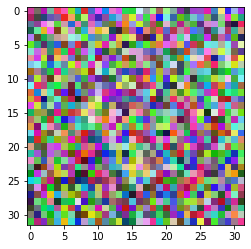



Adversarial image at step 5. L2 error 5368.736320777581 and class label 6.


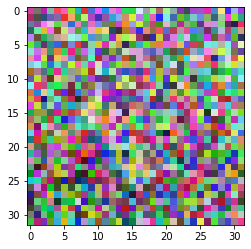



Adversarial image at step 6. L2 error 4962.065615036826 and class label 6.


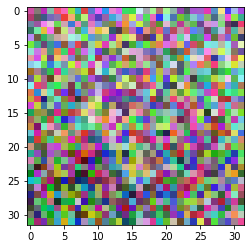



Adversarial image at step 7. L2 error 4398.547973226075 and class label 6.


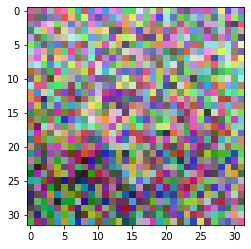



Adversarial image at step 8. L2 error 3649.639913506956 and class label 6.


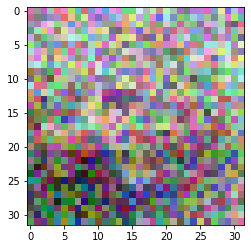



Adversarial image at step 9. L2 error 2718.0099151954164 and class label 6.


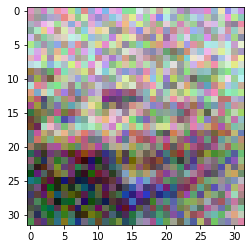



Adversarial image at step 10. L2 error 2024.1927239399786 and class label 6.


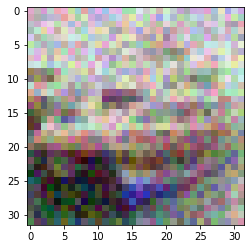



Adversarial image at step 11. L2 error 1794.312605785761 and class label 6.


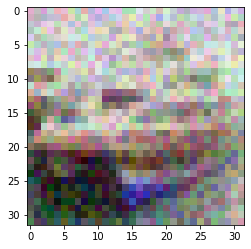



Adversarial image at step 12. L2 error 1733.8112256127836 and class label 6.


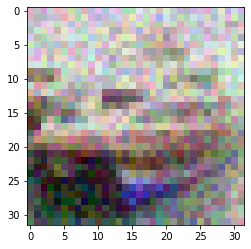



Adversarial image at step 13. L2 error 1694.8161880576838 and class label 6.


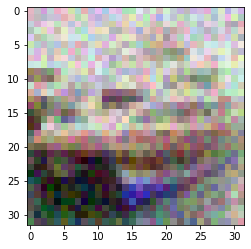



Adversarial image at step 14. L2 error 1669.2192542597313 and class label 6.


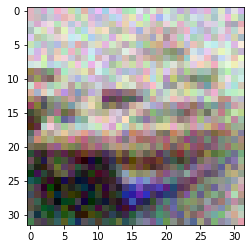



Adversarial image at step 15. L2 error 1644.1187249743016 and class label 6.


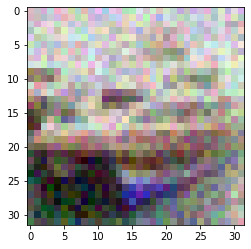



Adversarial image at step 16. L2 error 1619.4455180560874 and class label 6.


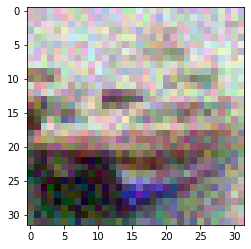



Adversarial image at step 17. L2 error 1582.9935037479645 and class label 6.


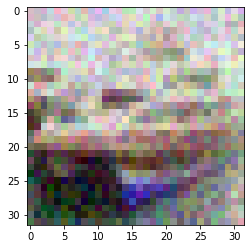



Adversarial image at step 18. L2 error 1547.1538298325725 and class label 6.


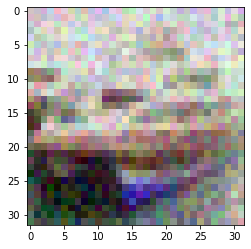



Adversarial image at step 19. L2 error 1512.2122227350176 and class label 6.


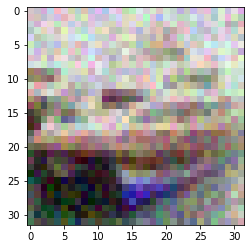



Adversarial image at step 20. L2 error 1478.1240217056256 and class label 6.


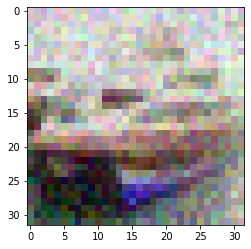



Adversarial image at step 21. L2 error 1455.7655591081384 and class label 6.


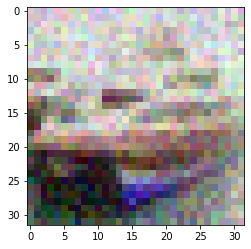



Adversarial image at step 22. L2 error 1422.927310508786 and class label 6.


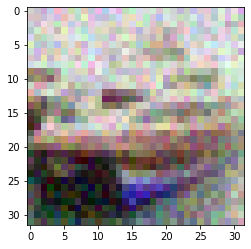



Adversarial image at step 23. L2 error 1390.7037944875474 and class label 6.


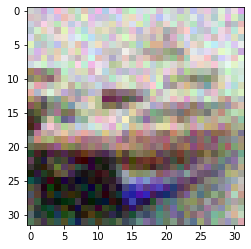



Adversarial image at step 24. L2 error 1359.3698778494638 and class label 6.


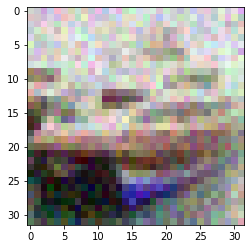



Adversarial image at step 25. L2 error 1328.7413624386527 and class label 6.


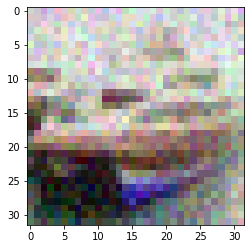



Adversarial image at step 26. L2 error 1308.6808560828167 and class label 6.


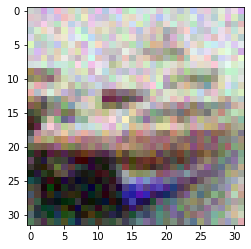



Adversarial image at step 27. L2 error 1288.9824300332032 and class label 6.


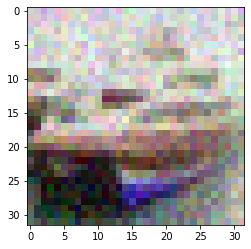



Adversarial image at step 28. L2 error 1275.9603712854482 and class label 6.


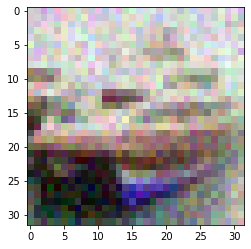



Adversarial image at step 29. L2 error 1263.1706912311026 and class label 6.


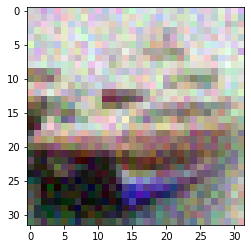



Adversarial image at step 30. L2 error 1250.5127856852475 and class label 6.


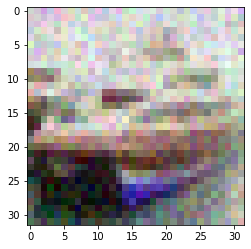



Adversarial image at step 31. L2 error 1237.965994239572 and class label 6.


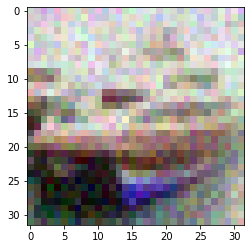



Adversarial image at step 32. L2 error 1229.6560624342064 and class label 6.


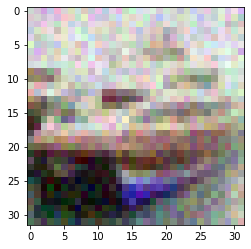



Adversarial image at step 33. L2 error 1221.4420031734142 and class label 6.


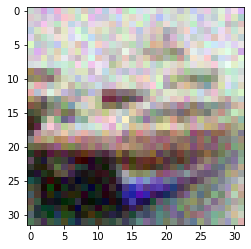



Adversarial image at step 34. L2 error 1209.1929398654765 and class label 6.


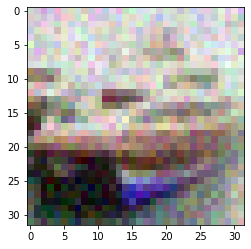



Adversarial image at step 35. L2 error 1197.0353586298738 and class label 6.


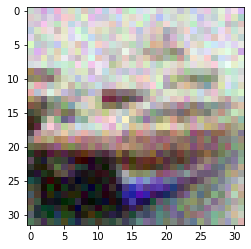



Adversarial image at step 36. L2 error 1189.0269855936724 and class label 6.


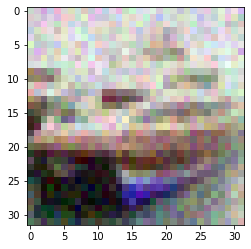



Adversarial image at step 37. L2 error 1181.0584913757132 and class label 6.


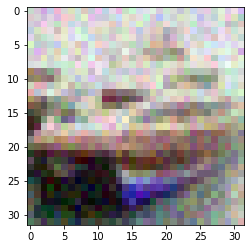



Adversarial image at step 38. L2 error 1173.099817419346 and class label 6.


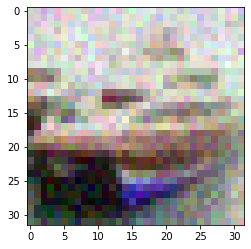



Adversarial image at step 39. L2 error 1161.3600175338784 and class label 6.


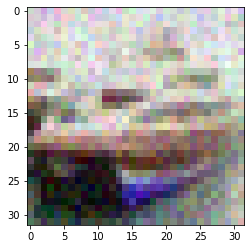



Adversarial image at step 40. L2 error 1153.5814280175982 and class label 6.


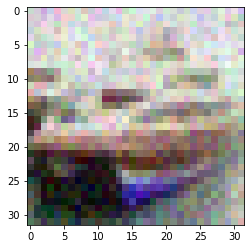



Adversarial image at step 41. L2 error 1145.8835505998293 and class label 6.


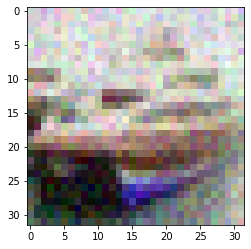



Adversarial image at step 42. L2 error 1140.7207868818716 and class label 6.


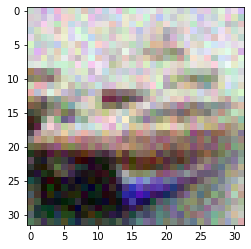



Adversarial image at step 43. L2 error 1135.5936069233405 and class label 6.


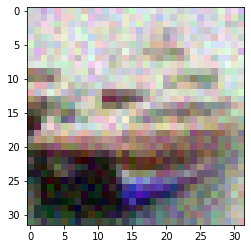



Adversarial image at step 44. L2 error 1130.5358895198174 and class label 6.


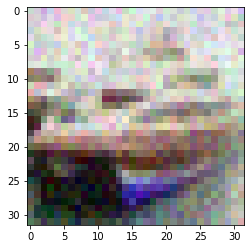



Adversarial image at step 45. L2 error 1125.4862261168246 and class label 6.


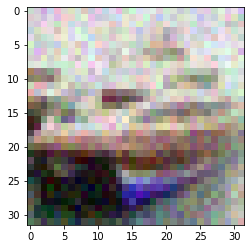



Adversarial image at step 46. L2 error 1117.8899487148815 and class label 6.


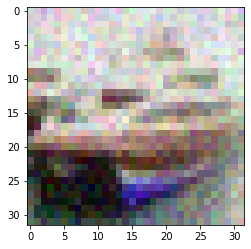



Adversarial image at step 47. L2 error 1106.6123260022794 and class label 6.


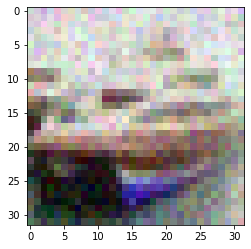



Adversarial image at step 48. L2 error 1089.9095200663783 and class label 6.


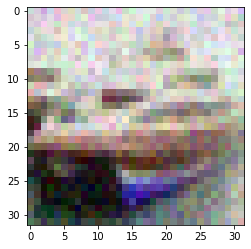



Adversarial image at step 49. L2 error 1073.500962151376 and class label 6.


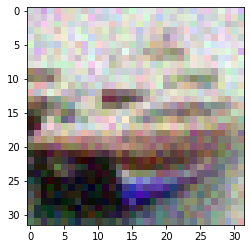



Adversarial image at step 50. L2 error 1062.5905743969417 and class label 6.


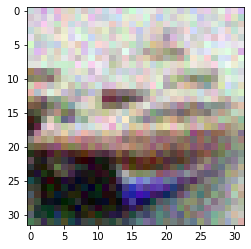



Adversarial image at step 51. L2 error 1055.4051161605523 and class label 6.


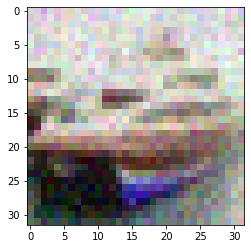



Adversarial image at step 52. L2 error 1048.3123884181364 and class label 6.


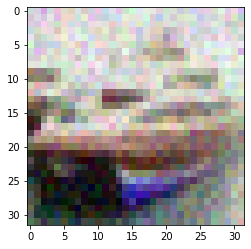



Adversarial image at step 53. L2 error 1037.7235864016136 and class label 6.


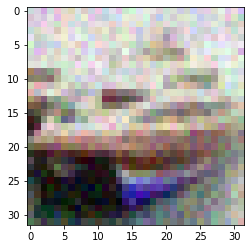



Adversarial image at step 54. L2 error 1030.6710426055386 and class label 6.


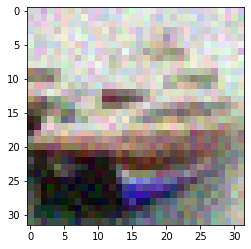



Adversarial image at step 55. L2 error 1020.3266783497477 and class label 6.


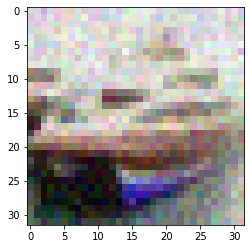



Adversarial image at step 56. L2 error 1013.450830332535 and class label 6.


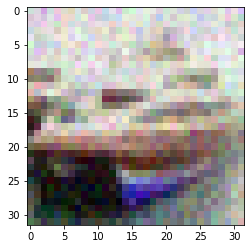



Adversarial image at step 57. L2 error 1006.602249828562 and class label 6.


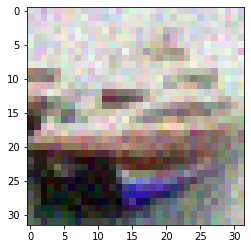



Adversarial image at step 58. L2 error 996.3747836503481 and class label 6.


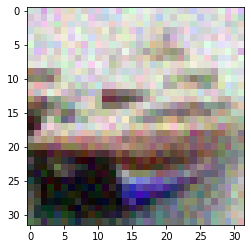



Adversarial image at step 59. L2 error 981.2939090862692 and class label 6.


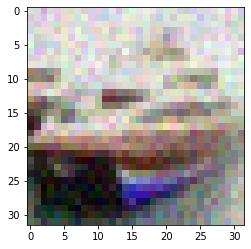



Adversarial image at step 60. L2 error 974.7122367282404 and class label 6.


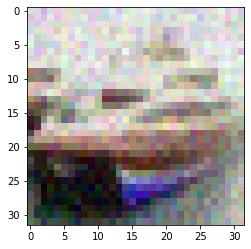



Adversarial image at step 61. L2 error 964.9574880237462 and class label 6.


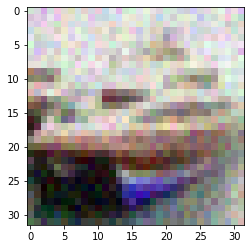



Adversarial image at step 62. L2 error 955.3048912163956 and class label 6.


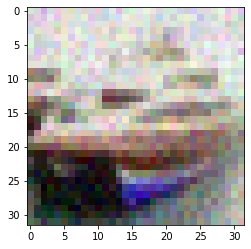



Adversarial image at step 63. L2 error 945.7233120989805 and class label 6.


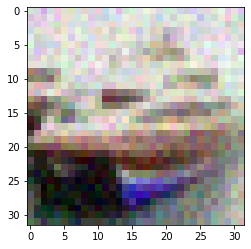



Adversarial image at step 64. L2 error 939.4051930155917 and class label 6.


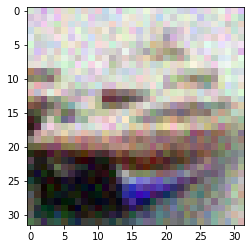



Adversarial image at step 65. L2 error 930.0025384530685 and class label 6.


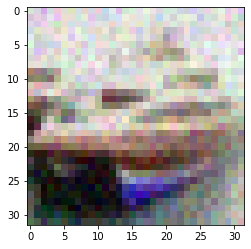



Adversarial image at step 66. L2 error 920.69671988188 and class label 6.


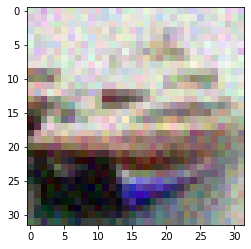



Adversarial image at step 67. L2 error 914.547573667116 and class label 6.


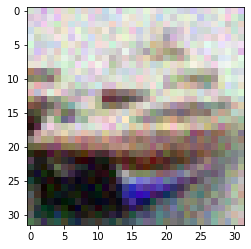



Adversarial image at step 68. L2 error 905.3858138468272 and class label 6.


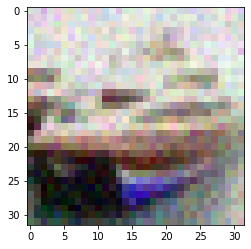



Adversarial image at step 69. L2 error 896.2761954201892 and class label 6.


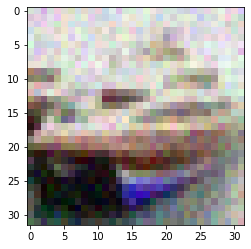



Adversarial image at step 70. L2 error 882.7942327610892 and class label 6.


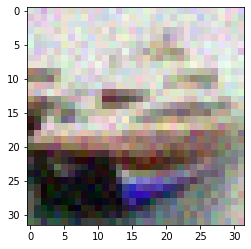



Adversarial image at step 71. L2 error 873.9091519774069 and class label 6.


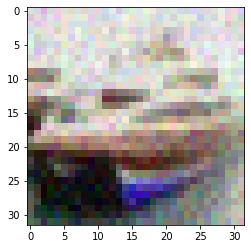



Adversarial image at step 72. L2 error 865.1138752812667 and class label 6.


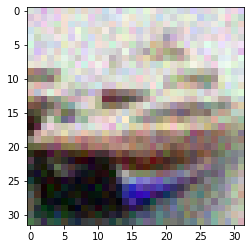



Adversarial image at step 73. L2 error 856.4337303914563 and class label 6.


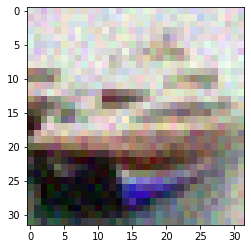



Adversarial image at step 74. L2 error 850.6957176966185 and class label 6.


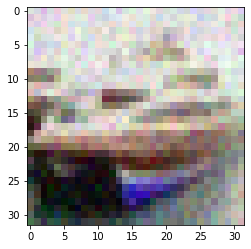



Adversarial image at step 75. L2 error 845.0113270906213 and class label 6.


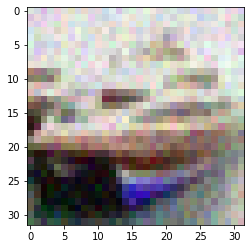



Adversarial image at step 76. L2 error 839.3596871503127 and class label 6.


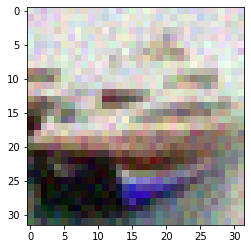



Adversarial image at step 77. L2 error 833.7427234709218 and class label 6.


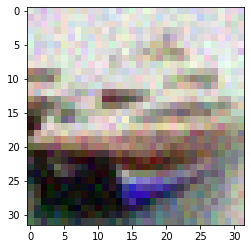



Adversarial image at step 78. L2 error 828.1516372536571 and class label 6.


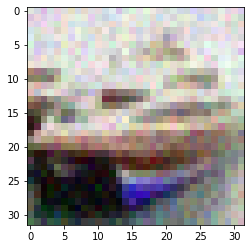



Adversarial image at step 79. L2 error 822.5740633038 and class label 6.


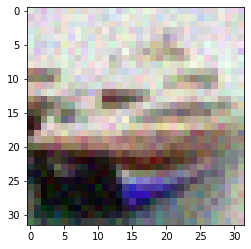



Adversarial image at step 80. L2 error 814.2721588847908 and class label 6.


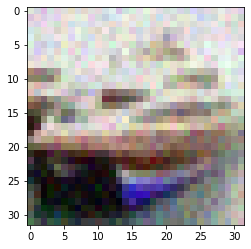



Adversarial image at step 81. L2 error 806.0644279055199 and class label 6.


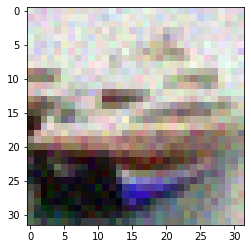



Adversarial image at step 82. L2 error 793.8021940091354 and class label 6.


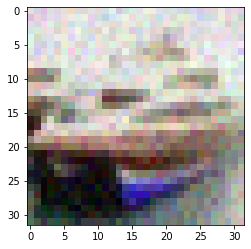



Adversarial image at step 83. L2 error 785.7993404741054 and class label 6.


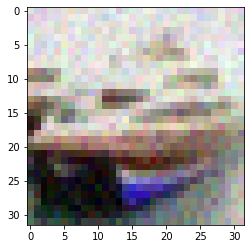



Adversarial image at step 84. L2 error 777.8160071248004 and class label 6.


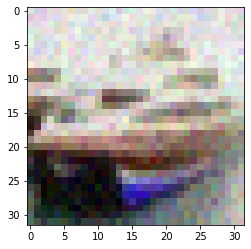



Adversarial image at step 85. L2 error 766.1435694578258 and class label 6.


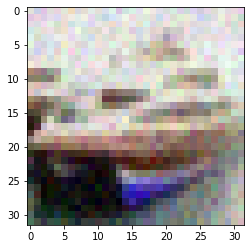



Adversarial image at step 86. L2 error 758.432700466528 and class label 6.


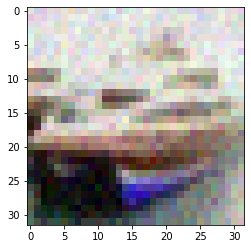



Adversarial image at step 87. L2 error 753.3388125021085 and class label 6.


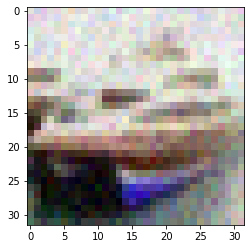



Adversarial image at step 88. L2 error 748.3060408306657 and class label 6.


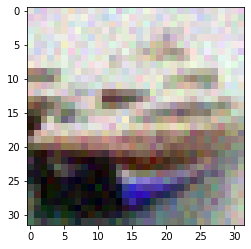



Adversarial image at step 89. L2 error 743.3099615567876 and class label 6.


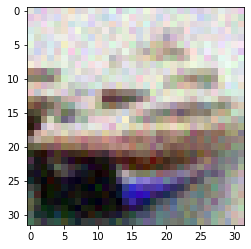



Adversarial image at step 90. L2 error 738.320391776165 and class label 6.


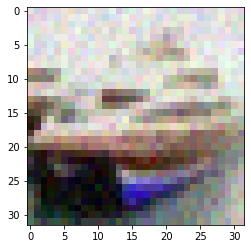



Adversarial image at step 91. L2 error 733.3805957372564 and class label 6.


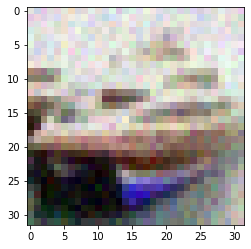



Adversarial image at step 92. L2 error 728.4846848802547 and class label 6.


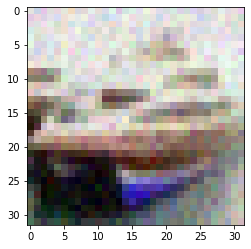



Adversarial image at step 93. L2 error 725.2034632383643 and class label 6.


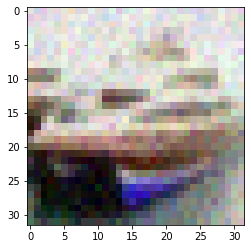



Adversarial image at step 94. L2 error 721.9680554327766 and class label 6.


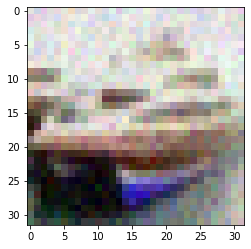



Adversarial image at step 95. L2 error 718.7453886874661 and class label 6.


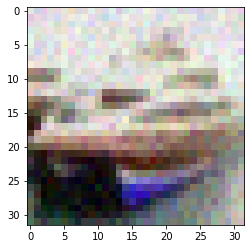



Adversarial image at step 96. L2 error 715.5415196511975 and class label 6.


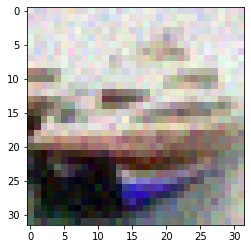



Adversarial image at step 97. L2 error 712.3534644743855 and class label 6.


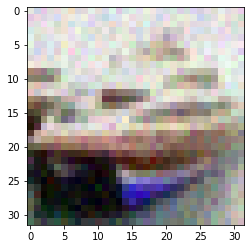



Adversarial image at step 98. L2 error 709.1778196803516 and class label 6.


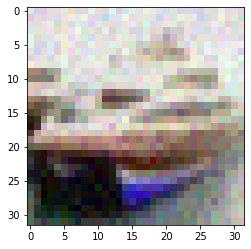



Adversarial image at step 99. L2 error 704.419358736809 and class label 6.


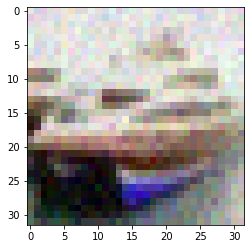

In [30]:
classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_without_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
target=X_test[1]
image_list=[]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_without_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break



Adversarial image at step 0. L2 error 6137.150368638682 and class label 4.


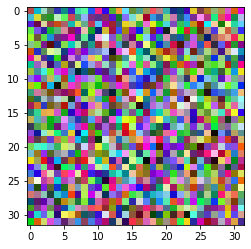



Adversarial image at step 1. L2 error 6075.7763412640825 and class label 4.


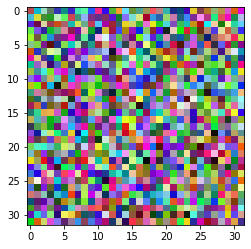



Adversarial image at step 2. L2 error 5984.685244446807 and class label 4.


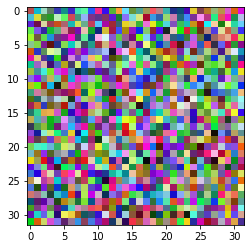



Adversarial image at step 3. L2 error 5850.164371041325 and class label 4.


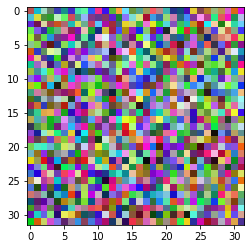



Adversarial image at step 4. L2 error 5653.017173514926 and class label 4.


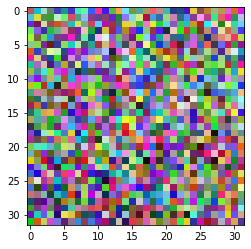



Adversarial image at step 5. L2 error 5367.404809514257 and class label 4.


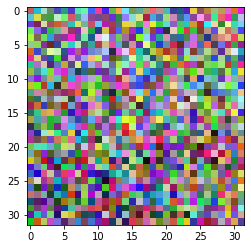



Adversarial image at step 6. L2 error 4960.834969671624 and class label 4.


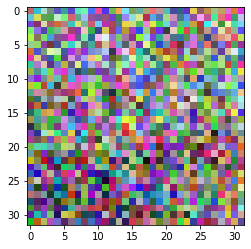



Adversarial image at step 7. L2 error 4397.456820677801 and class label 4.


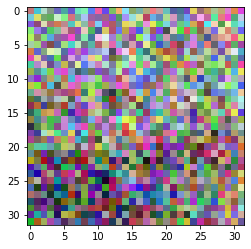



Adversarial image at step 8. L2 error 3898.0576509818084 and class label 4.


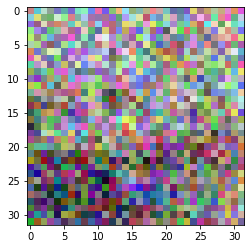



Adversarial image at step 9. L2 error 3766.695263168341 and class label 4.


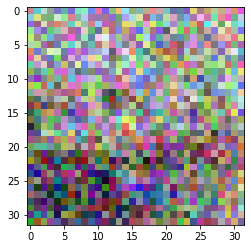



Adversarial image at step 10. L2 error 3682.0255662122977 and class label 4.


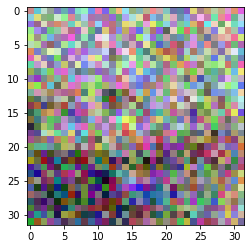



Adversarial image at step 11. L2 error 3626.773869441732 and class label 4.


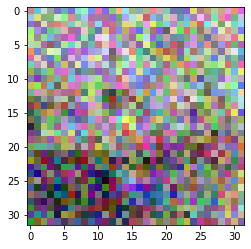



Adversarial image at step 12. L2 error 3572.335780971879 and class label 4.


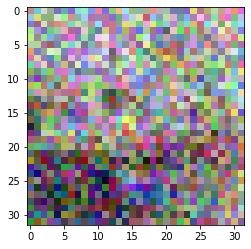



Adversarial image at step 13. L2 error 3491.742741198968 and class label 4.


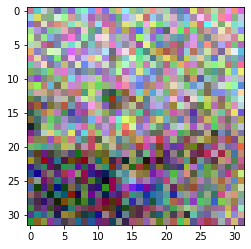



Adversarial image at step 14. L2 error 3373.045770834937 and class label 4.


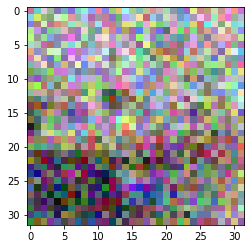



Adversarial image at step 15. L2 error 3201.238987210773 and class label 4.


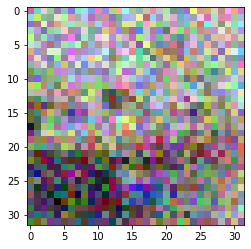



Adversarial image at step 16. L2 error 3091.6963558777825 and class label 4.


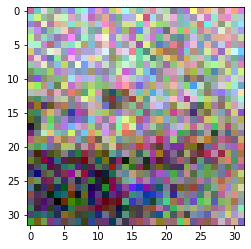



Adversarial image at step 17. L2 error 2985.6995759049473 and class label 4.


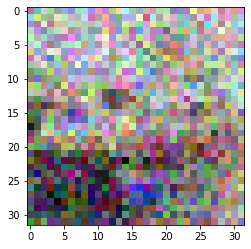



Adversarial image at step 18. L2 error 2831.607570260444 and class label 4.


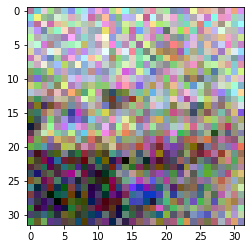



Adversarial image at step 19. L2 error 2733.5716795749677 and class label 4.


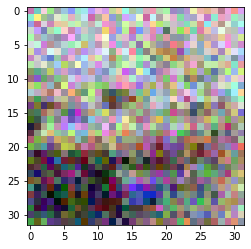



Adversarial image at step 20. L2 error 2638.279793729628 and class label 4.


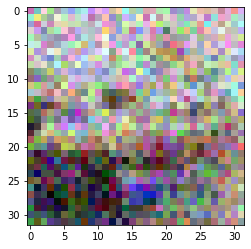



Adversarial image at step 21. L2 error 2499.248162644253 and class label 4.


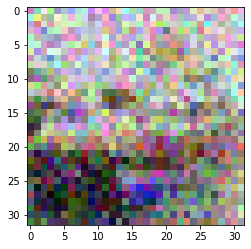



Adversarial image at step 22. L2 error 2359.922496488146 and class label 4.


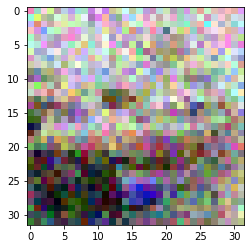



Adversarial image at step 23. L2 error 2269.1688167511898 and class label 4.


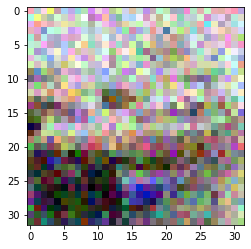



Adversarial image at step 24. L2 error 2239.6659333691196 and class label 4.


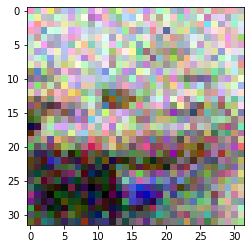



Adversarial image at step 25. L2 error 2202.140887864939 and class label 4.


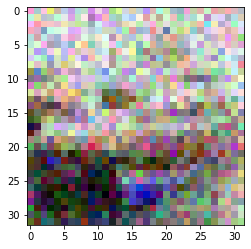



Adversarial image at step 26. L2 error 2166.2005495042763 and class label 4.


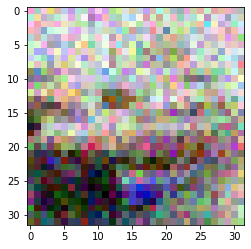



Adversarial image at step 27. L2 error 2111.0419859520257 and class label 4.


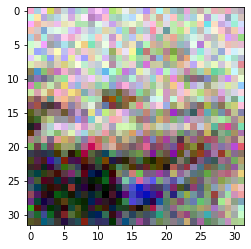



Adversarial image at step 28. L2 error 2076.4711004989044 and class label 4.


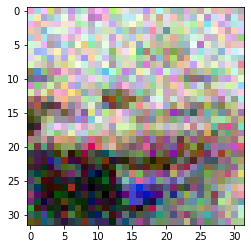



Adversarial image at step 29. L2 error 2043.6354571482752 and class label 4.


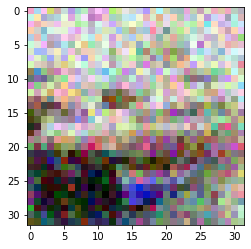



Adversarial image at step 30. L2 error 2021.3158438015225 and class label 4.


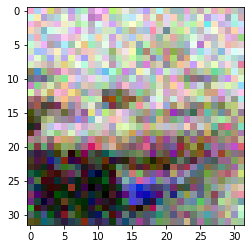



Adversarial image at step 31. L2 error 1988.6877865783058 and class label 4.


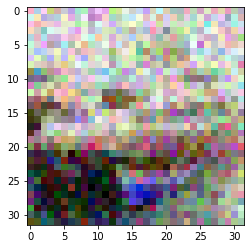



Adversarial image at step 32. L2 error 1942.5293082264488 and class label 4.


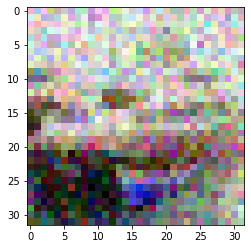



Adversarial image at step 33. L2 error 1875.4311199577883 and class label 4.


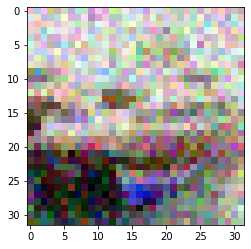



Adversarial image at step 34. L2 error 1810.0622241800622 and class label 4.


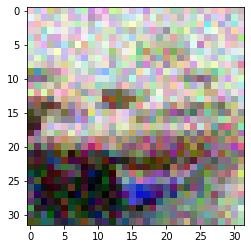



Adversarial image at step 35. L2 error 1748.0602500871576 and class label 4.


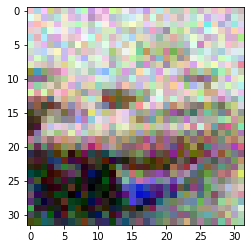



Adversarial image at step 36. L2 error 1687.6752946189492 and class label 4.


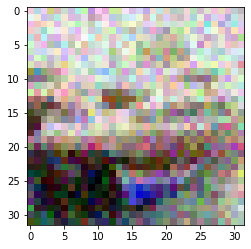



Adversarial image at step 37. L2 error 1628.9694823914078 and class label 4.


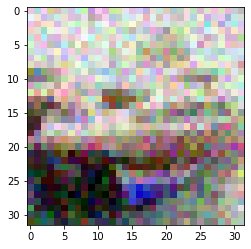



Adversarial image at step 38. L2 error 1591.0088883095334 and class label 4.


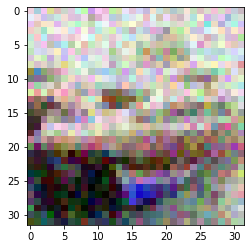



Adversarial image at step 39. L2 error 1554.403198971084 and class label 4.


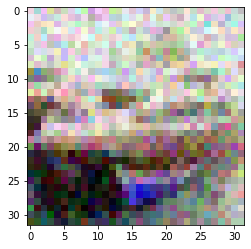



Adversarial image at step 40. L2 error 1529.7423689488037 and class label 4.


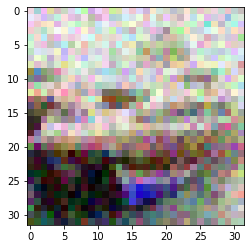



Adversarial image at step 41. L2 error 1505.8761027430864 and class label 4.


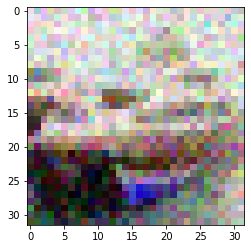



Adversarial image at step 42. L2 error 1482.5950508644787 and class label 4.


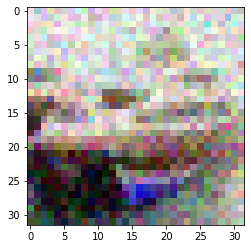



Adversarial image at step 43. L2 error 1466.7666226802094 and class label 4.


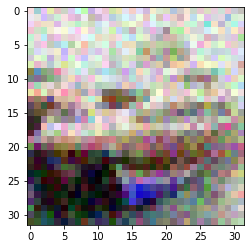



Adversarial image at step 44. L2 error 1444.0145543749059 and class label 4.


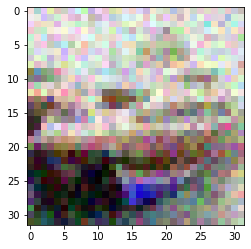



Adversarial image at step 45. L2 error 1410.6379058032637 and class label 4.


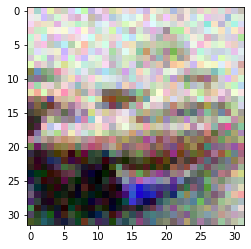



Adversarial image at step 46. L2 error 1377.8963420788155 and class label 4.


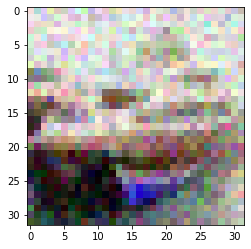



Adversarial image at step 47. L2 error 1330.4872555190104 and class label 4.


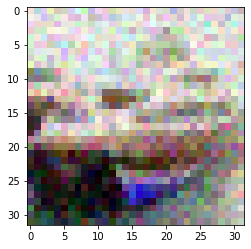



Adversarial image at step 48. L2 error 1299.8108845771965 and class label 4.


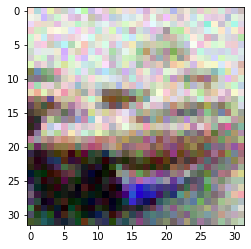



Adversarial image at step 49. L2 error 1279.9566865221004 and class label 4.


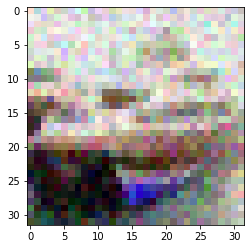



Adversarial image at step 50. L2 error 1266.5346032063985 and class label 4.


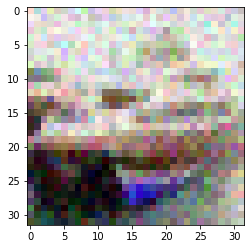



Adversarial image at step 51. L2 error 1247.1039436231558 and class label 4.


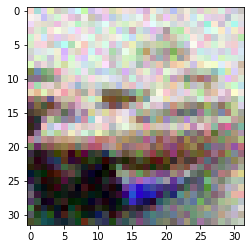



Adversarial image at step 52. L2 error 1233.5355354803025 and class label 4.


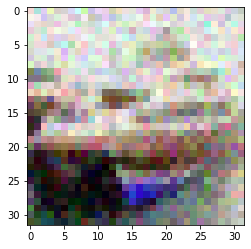



Adversarial image at step 53. L2 error 1220.5721661389189 and class label 4.


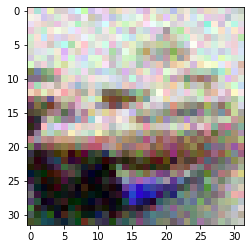



Adversarial image at step 54. L2 error 1201.9490901793804 and class label 4.


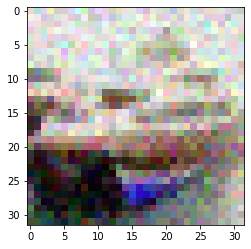



Adversarial image at step 55. L2 error 1193.709395299339 and class label 4.


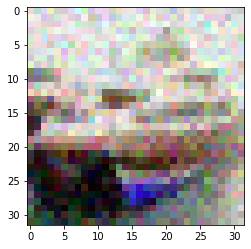



Adversarial image at step 56. L2 error 1185.353501443777 and class label 4.


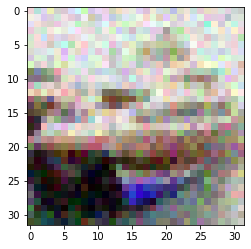



Adversarial image at step 57. L2 error 1177.0861915430535 and class label 4.


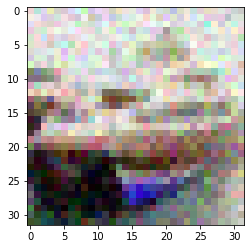



Adversarial image at step 58. L2 error 1168.8953821804955 and class label 4.


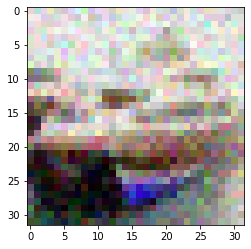



Adversarial image at step 59. L2 error 1163.4513676538547 and class label 4.


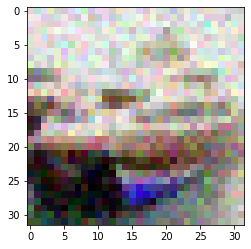



Adversarial image at step 60. L2 error 1159.586771190853 and class label 4.


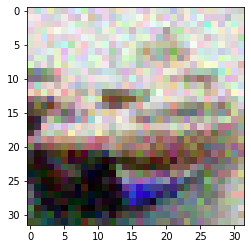



Adversarial image at step 61. L2 error 1154.2662076140969 and class label 4.


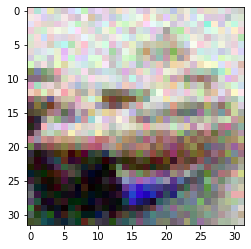



Adversarial image at step 62. L2 error 1148.9238734182773 and class label 4.


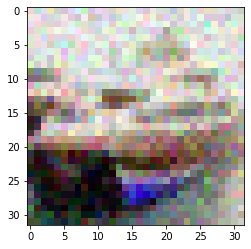



Adversarial image at step 63. L2 error 1140.9121990372971 and class label 4.


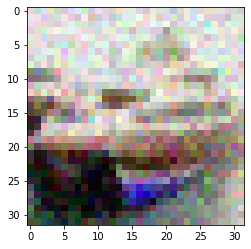



Adversarial image at step 64. L2 error 1132.9040391007943 and class label 4.


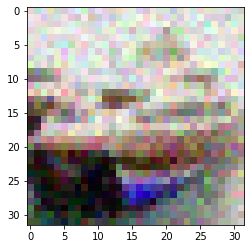



Adversarial image at step 65. L2 error 1120.4133606024789 and class label 4.


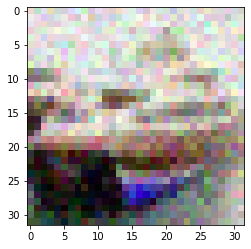



Adversarial image at step 66. L2 error 1118.7822547610463 and class label 4.


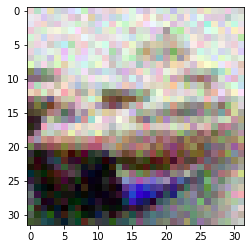



Adversarial image at step 67. L2 error 1117.0581075993682 and class label 4.


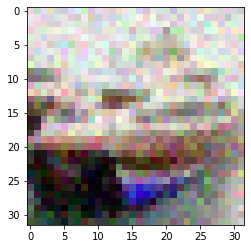



Adversarial image at step 68. L2 error 1114.5443922486259 and class label 4.


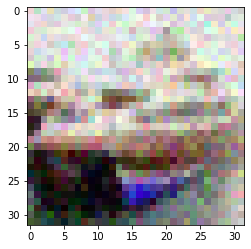



Adversarial image at step 69. L2 error 1110.8501222436323 and class label 4.


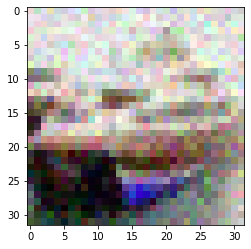



Adversarial image at step 70. L2 error 1105.5271256252197 and class label 4.


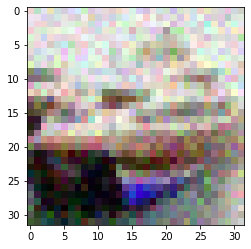



Adversarial image at step 71. L2 error 1100.2558698708622 and class label 4.


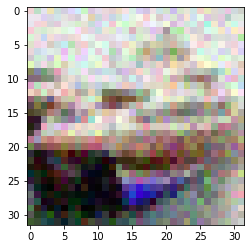



Adversarial image at step 72. L2 error 1092.6643266471601 and class label 4.


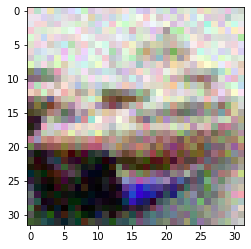



Adversarial image at step 73. L2 error 1084.9602036056926 and class label 4.


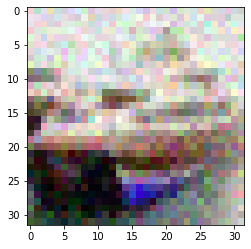



Adversarial image at step 74. L2 error 1076.7035308929014 and class label 4.


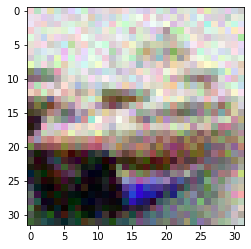



Adversarial image at step 75. L2 error 1068.6517333600257 and class label 4.


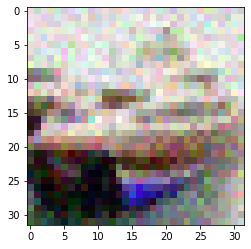



Adversarial image at step 76. L2 error 1057.239740838752 and class label 4.


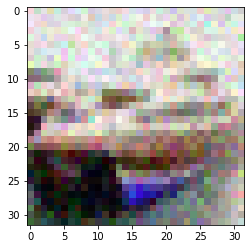



Adversarial image at step 77. L2 error 1045.885148380921 and class label 4.


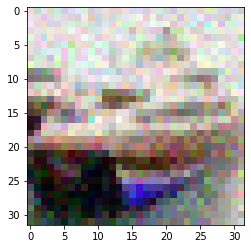



Adversarial image at step 78. L2 error 1034.8730682088478 and class label 4.


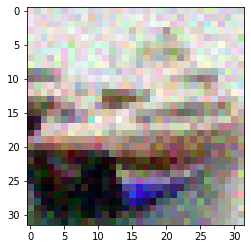



Adversarial image at step 79. L2 error 1024.262559261292 and class label 4.


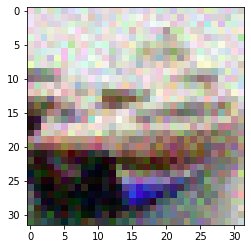



Adversarial image at step 80. L2 error 1017.298111148817 and class label 4.


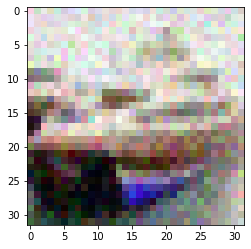



Adversarial image at step 81. L2 error 1010.3664647246798 and class label 4.


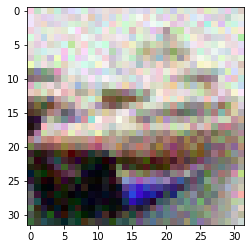



Adversarial image at step 82. L2 error 1000.0018005822878 and class label 4.


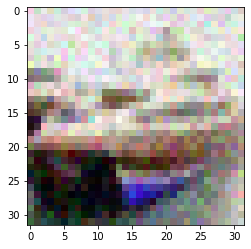



Adversarial image at step 83. L2 error 989.8772303879153 and class label 4.


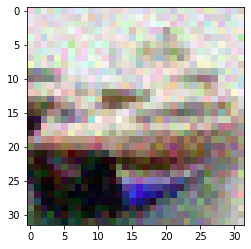



Adversarial image at step 84. L2 error 979.8611216663605 and class label 4.


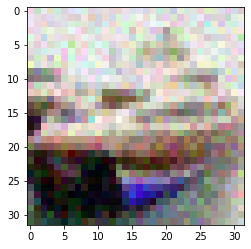



Adversarial image at step 85. L2 error 975.3079837304278 and class label 4.


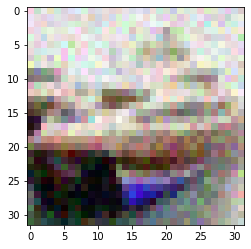



Adversarial image at step 86. L2 error 972.3127069119655 and class label 4.


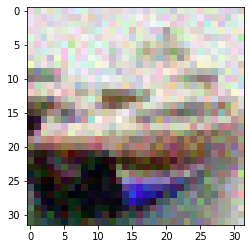



Adversarial image at step 87. L2 error 969.1277656264557 and class label 4.


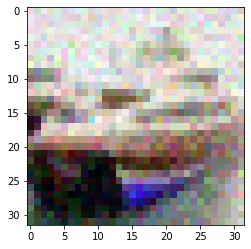



Adversarial image at step 88. L2 error 966.1660052547387 and class label 4.


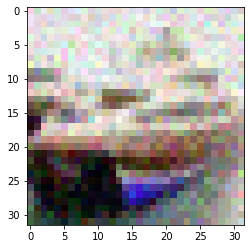



Adversarial image at step 89. L2 error 961.8157444007162 and class label 4.


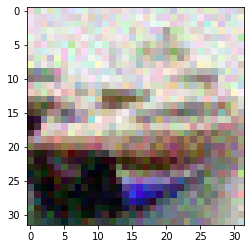



Adversarial image at step 98. L2 error 908.3158546646573 and class label 4.


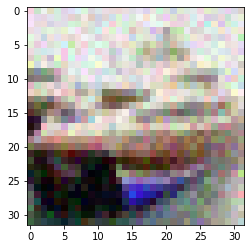



Adversarial image at step 99. L2 error 904.143974320076 and class label 4.


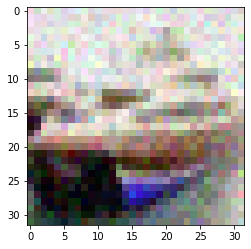

In [31]:
classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_with_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[1]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_with_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


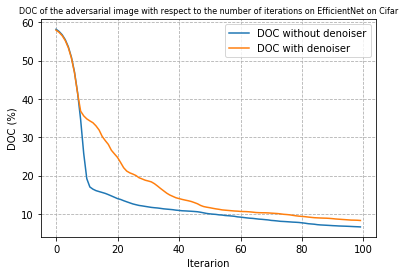

In [32]:
plt.plot(list(degree_of_change_without_def.keys()),list(degree_of_change_without_def.values()),label='DOC without denoiser')
plt.plot(list(degree_of_change_with_def.keys()),list(degree_of_change_with_def.values()),label='DOC with denoiser')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet on Cifar', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()